In [3]:
'''
This block is used to import all libraries we will use in the project
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, scale, minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from numpy import array
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

Using TensorFlow backend.


In [336]:
'''
This block is used to define all function we will use in the project
'''


def create_data(data_X, data_Y, number_X, number_Y):
    '''
    Basic idea:
    create several sub-dataframes and concat them together.
    For instance:
    Samples : 1,2,3,4,5,6,7
    number X = 3
    number Y = 2
    
    for measurements, create data frames:
    1    |    2    |    3
    2    |    3    |    4
    3    |    4    |    5
    
    Then concat them together, we can get 3 new sample measurements:
    
    Sample 1: 1, 2, 3
    Sample 2: 2, 3, 4
    Sample 3: 3, 4, 5
    '''
    
    # to get the coloumn names
    features_name = [col for col in data_X]
    target_name = [col for col in data_Y]
    X_shape = data_X.shape
    index_X = data_X.index
    number_samples = X_shape[0]
    
    number_to_delete = number_X + number_Y -1
    number_measurements = number_samples - number_to_delete
    temp_X = []
    rst_df = None
    rst_index = None
    # create number_X dataframes and concat them together
    # for each dataframe, we should delete number_X -1 entries
    # create the delete lish
    for i in range(number_X):
        data_copy = data_X.copy()
        '''
        del_list contains the index of samples which should be deleted for each sub-dataframes
        '''
        del_list = []
        
        for j in range(i):
            del_list.append(index_X[j])
        for k in range(number_to_delete - i):
            del_list.append(index_X[number_samples - k -1])
        if i == 0:
            # the first sub-dataframe, create it directly
            rst_df = data_copy.drop(del_list, axis=0)
            rst_df.columns = [j+str(i) for j in features_name]
            rst_index = rst_df.index
        else:
            # concat the new sub-dataframe with the previous result
#             print(del_list)
            temp_df = data_copy.drop(del_list, axis=0)
            temp_df.index = rst_index
            temp_df.columns = [j+str(i) for j in features_name]
            rst_df = pd.concat([rst_df, temp_df], axis=1)
#             print(rst_df.shape)
            
    for i in range(number_Y):
        target_copy = data_Y.copy()
        del_list = []
        for j in range(number_X + i -1):
            del_list.append(index_X[j])
        for k in range(number_Y - i):
            del_list.append(index_X[number_samples - k -1])
#         print(del_list)
        if i == 0:
            tgt_df = target_copy.drop(del_list, axis=0)
            tgt_df.columns = [j+str(i) for j in target_name]
            tgt_index = tgt_df.index
        else:
#             print(del_list)
            temp_df = target_copy.drop(del_list, axis=0)
            temp_df.index = tgt_index
            temp_df.columns = [j+str(i) for j in target_name]
            tgt_df = pd.concat([tgt_df, temp_df], axis=1)
            print(tgt_df.shape)
    return rst_df, tgt_df


def RNN_reshape(data, number_X, n_features):
    X = data.to_numpy()
    X = X.reshape(X.shape[0], number_X, n_features)
    return X


def BuildRNN_Multi_Step_LSTM(input_X, input_Y, number_X, number_Y, n_features):
    X = RNN_reshape(input_X, number_X, n_features)
#     print(X)
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(number_X, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(number_Y))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(X, input_Y, epochs=100, verbose=1, batch_size=1000)
    return model

def Build_Encoder_Decoder_LSTM(input_X, input_Y, number_X, number_Y, n_features, n_target):
    X = RNN_reshape(input_X, number_X, n_features)
    Y = RNN_reshape(input_Y, number_Y, n_target)
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(number_X, 16)))
    model.add(RepeatVector(number_Y))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(X, Y, epochs=100, verbose=1, batch_size=1000)
    return model


# input data should be np array, only outliers in X will be considered
def OutlierRemoval(InputX, InputY, Threhold):
    
    Y_FeatureColumn = [i for i in range(len(InputX[0]), len(InputX[0]) + len(InputY[0]))]
    
    # combine X and Y
    combine_data = np.c_[InputX, InputY]
    
    # remove outlier in X
    removed_data = combine_data[np.all(np.abs(np.delete(combine_data, Y_FeatureColumn, 1)) < Threhold ,axis=1)]
    
    # spilit removed_data into X and Y
    removed_x = np.delete(removed_data, Y_FeatureColumn, 1)
    removed_y = removed_data[:,Y_FeatureColumn]
    
    return removed_x, removed_y

# All input data should be np array
def CalculateNMAE(PredictData, TestData):
    return mean_absolute_error(PredictData, TestData)/TestData.mean()


# feature selection, only return X since we don't change Y
def TreeBasedSelection(InputX, InputY, FeatureNumber):
    # create and fit selector
    clf = ExtraTreesRegressor()
    clf = clf.fit(InputX, InputY)
    
    # only number of sorted features will be selected, and we disable threshold
    model = SelectFromModel(clf, prefit=True, max_features = FeatureNumber, threshold=-np.inf)
    OutputX = model.transform(InputX)
    return OutputX

# standardize column value
def ColumnStandardize(Input):
    Scaler = StandardScaler()
    return Scaler.fit_transform(Input)

In [7]:
'''
Read data from file
'''
# fileName_X = '../VoD_Periodic_2017/X.csv'
# fileName_Y = '../VoD_Periodic_2017/Y.csv'
fileName_X = '../KV_flash/X.csv'
fileName_Y = '../KV_flash/Y.csv'
# fileName_X = './KV_flash/VOD_X.csv'
# fileName_Y = './KV_flash/VOD_Y.csv'
# fileName_X = '../X.csv'
# fileName_Y = '../Y.csv'
# fileName_X = './VoD_flash/X.csv'
# fileName_Y = './VoD_flash/Y.csv'

In [8]:
'''
Read data from csv file.
X and Y are raw data
Y_notime and Y_notime are data without timestamp
X_features are a list which contains the name of all of the features in X
'''
X = pd.read_csv(fileName_X)
Y = pd.read_csv(fileName_Y)[['TimeStamp', 'WritesAvg']]
# Y = pd.read_csv(fileName_Y)[['TimeStamp', 'DispFrames']]
X_notime = X.drop('TimeStamp',axis=1)
Y_notime = Y.drop(['TimeStamp'],axis=1)
timeIndex_x=pd.to_datetime(X['TimeStamp'])
timeIndex_y=pd.to_datetime(Y['TimeStamp'])
X.index=timeIndex_x
Y.index=timeIndex_y
X_notime.index = timeIndex_x
Y_notime.index = timeIndex_y
X_features = [col for col in X_notime]
np.random.seed(0)

In [9]:
# change from dataframe to np array
X_npArray = X_notime.to_numpy()
Y_npArray = Y_notime.to_numpy()

# standardize the data
X_Standard = ColumnStandardize(X_npArray)

# remove outlier with threshold 100
X_NoOutlier, Y_NoOutlier = OutlierRemoval(X_Standard, Y_npArray, 100)

# tree based feature selection and have only 16 features
X_FeatureSelection = TreeBasedSelection(X_NoOutlier, Y_NoOutlier, 16)

/home/yao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/yao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [10]:
# change X from np array back to dataframe

feature_name = []
for i in range(16):
    feature_name.append('feature'+str(i+1))
    
X_BackToDF = pd.DataFrame(data = X_FeatureSelection,  columns=feature_name)

Y_BackToDF = pd.DataFrame(data = Y_NoOutlier,  columns=Y_notime.columns)

In [11]:
# train set split and sort by index

X_train, X_test, Y_train, Y_test = train_test_split(X_BackToDF, Y_BackToDF, test_size=0.3, random_state=1)
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)

In [17]:
'''
Task 1, train the data using linear regression model
'''

Linear = LinearRegression()
NMAE_table = []

for h in range(1, 12):
    temp_list = []
    print(NMAE_table)
    for l in range(1, 12):
        xtrain, ytrain = create_data(X_train, Y_train, l, h)
        xtest, ytest = create_data(X_test, Y_test, l, h)
        Linear.fit(xtrain, ytrain)
        pred = Linear.predict(xtest)
        temp_list.append(round(CalculateNMAE(pred, ytest)[0], 4))
    NMAE_table.append(temp_list)

[]
[[0.108, 0.107, 0.1066, 0.1063, 0.1061, 0.1061, 0.1062, 0.1061, 0.1061, 0.1062, 0.1063]]
(25873, 2)
(11088, 2)
(25872, 2)
(11087, 2)
(25871, 2)
(11086, 2)
(25870, 2)
(11085, 2)
(25869, 2)
(11084, 2)
(25868, 2)
(11083, 2)
(25867, 2)
(11082, 2)
(25866, 2)
(11081, 2)
(25865, 2)
(11080, 2)
(25864, 2)
(11079, 2)
(25863, 2)
(11078, 2)
[[0.108, 0.107, 0.1066, 0.1063, 0.1061, 0.1061, 0.1062, 0.1061, 0.1061, 0.1062, 0.1063], [0.108, 0.1071, 0.1067, 0.1064, 0.1062, 0.1062, 0.1063, 0.1062, 0.1062, 0.1063, 0.1065]]
(25872, 2)
(25872, 3)
(11087, 2)
(11087, 3)
(25871, 2)
(25871, 3)
(11086, 2)
(11086, 3)
(25870, 2)
(25870, 3)
(11085, 2)
(11085, 3)
(25869, 2)
(25869, 3)
(11084, 2)
(11084, 3)
(25868, 2)
(25868, 3)
(11083, 2)
(11083, 3)
(25867, 2)
(25867, 3)
(11082, 2)
(11082, 3)
(25866, 2)
(25866, 3)
(11081, 2)
(11081, 3)
(25865, 2)
(25865, 3)
(11080, 2)
(11080, 3)
(25864, 2)
(25864, 3)
(11079, 2)
(11079, 3)
(25863, 2)
(25863, 3)
(11078, 2)
(11078, 3)
(25862, 2)
(25862, 3)
(11077, 2)
(11077, 3)
[[0.

(25863, 2)
(25863, 3)
(25863, 4)
(25863, 5)
(25863, 6)
(25863, 7)
(25863, 8)
(11078, 2)
(11078, 3)
(11078, 4)
(11078, 5)
(11078, 6)
(11078, 7)
(11078, 8)
(25862, 2)
(25862, 3)
(25862, 4)
(25862, 5)
(25862, 6)
(25862, 7)
(25862, 8)
(11077, 2)
(11077, 3)
(11077, 4)
(11077, 5)
(11077, 6)
(11077, 7)
(11077, 8)
(25861, 2)
(25861, 3)
(25861, 4)
(25861, 5)
(25861, 6)
(25861, 7)
(25861, 8)
(11076, 2)
(11076, 3)
(11076, 4)
(11076, 5)
(11076, 6)
(11076, 7)
(11076, 8)
(25860, 2)
(25860, 3)
(25860, 4)
(25860, 5)
(25860, 6)
(25860, 7)
(25860, 8)
(11075, 2)
(11075, 3)
(11075, 4)
(11075, 5)
(11075, 6)
(11075, 7)
(11075, 8)
(25859, 2)
(25859, 3)
(25859, 4)
(25859, 5)
(25859, 6)
(25859, 7)
(25859, 8)
(11074, 2)
(11074, 3)
(11074, 4)
(11074, 5)
(11074, 6)
(11074, 7)
(11074, 8)
(25858, 2)
(25858, 3)
(25858, 4)
(25858, 5)
(25858, 6)
(25858, 7)
(25858, 8)
(11073, 2)
(11073, 3)
(11073, 4)
(11073, 5)
(11073, 6)
(11073, 7)
(11073, 8)
(25857, 2)
(25857, 3)
(25857, 4)
(25857, 5)
(25857, 6)
(25857, 7)
(25857, 8)

(25861, 2)
(25861, 3)
(25861, 4)
(25861, 5)
(25861, 6)
(25861, 7)
(25861, 8)
(25861, 9)
(25861, 10)
(25861, 11)
(11076, 2)
(11076, 3)
(11076, 4)
(11076, 5)
(11076, 6)
(11076, 7)
(11076, 8)
(11076, 9)
(11076, 10)
(11076, 11)
(25860, 2)
(25860, 3)
(25860, 4)
(25860, 5)
(25860, 6)
(25860, 7)
(25860, 8)
(25860, 9)
(25860, 10)
(25860, 11)
(11075, 2)
(11075, 3)
(11075, 4)
(11075, 5)
(11075, 6)
(11075, 7)
(11075, 8)
(11075, 9)
(11075, 10)
(11075, 11)
(25859, 2)
(25859, 3)
(25859, 4)
(25859, 5)
(25859, 6)
(25859, 7)
(25859, 8)
(25859, 9)
(25859, 10)
(25859, 11)
(11074, 2)
(11074, 3)
(11074, 4)
(11074, 5)
(11074, 6)
(11074, 7)
(11074, 8)
(11074, 9)
(11074, 10)
(11074, 11)
(25858, 2)
(25858, 3)
(25858, 4)
(25858, 5)
(25858, 6)
(25858, 7)
(25858, 8)
(25858, 9)
(25858, 10)
(25858, 11)
(11073, 2)
(11073, 3)
(11073, 4)
(11073, 5)
(11073, 6)
(11073, 7)
(11073, 8)
(11073, 9)
(11073, 10)
(11073, 11)
(25857, 2)
(25857, 3)
(25857, 4)
(25857, 5)
(25857, 6)
(25857, 7)
(25857, 8)
(25857, 9)
(25857, 10)
(258

In [40]:
'''
Try using naive method
'''
y_naive = pd.DataFrame({'result':[Y_train.mean()]*len(Y_test)})

In [41]:
CalculateNMAE(y_naive, Y_test)

WritesAvg    0.041062
dtype: float64

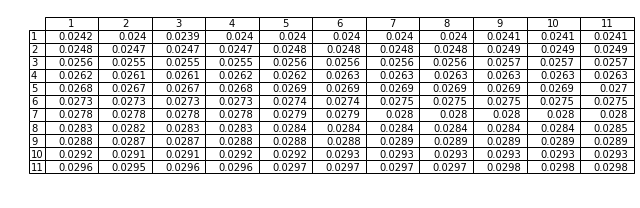

In [305]:
ColLable = [i for i in range(1, 12)]
RowLable = [i for i in range(1, 12)]
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('off')
ax.axis('tight')

ax.table(cellText=NMAE_table, rowLabels= RowLable, colLabels = ColLable, loc='center')
fig.tight_layout()
plt.show()

In [195]:
xtrain, ytrain = create_data(X_train, Y_train, 1, 1)
xtest, ytest = create_data(X_test, Y_test, 1, 1)
Linear = LinearRegression()
Linear.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [196]:
pred = Linear.predict(xtest)

In [197]:
# print(CalculateNMAE(pred[:,1], ytest['WritesAvg1']))
print(CalculateNMAE(pred[:,0], ytest['WritesAvg0']))
print(CalculateNMAE(pred, ytest))

0.024153412894430955
WritesAvg0    0.024153
dtype: float64


In [65]:
'''
Task 2, train the network with the model in function BuildRNN_Multi_Step_LSTM.
This model will use a RNN network followed by a Dense Layer
'''
RNN_NMAE_table = []
for h in range(1, 12):
    temp_list = []
    print(RNN_NMAE_table)
    for l in range(1, 12):
        RNN_xtrain, RNN_ytrain = create_data(X_train, Y_train, l, h)
        RNN_xtest, RNN_ytest = create_data(X_test, Y_test, l, h)
        RNNmodel = BuildRNN_Multi_Step_LSTM(RNN_xtrain, RNN_ytrain, l, h, 16)
        RNNtest = RNN_reshape(RNN_xtest, l, 16)
        RNNpred = RNNmodel.predict(RNNtest)
        temp_list.append(round(np.mean(CalculateNMAE(RNNpred, RNN_ytest)), 4))
    RNN_NMAE_table.append(temp_list)

[]
Epoch 1/50
13553/13553 [==============================] - 14s 1ms/step - loss: 12216.5020
Epoch 2/50
13553/13553 [==============================] - 1s 62us/step - loss: 12151.9588
Epoch 3/50
13553/13553 [==============================] - 1s 61us/step - loss: 11851.1795
Epoch 4/50
13553/13553 [==============================] - 1s 62us/step - loss: 10423.5830
Epoch 5/50
13553/13553 [==============================] - 1s 61us/step - loss: 6905.1543
Epoch 6/50
13553/13553 [==============================] - 1s 61us/step - loss: 3485.5468
Epoch 7/50
13553/13553 [==============================] - 1s 61us/step - loss: 2382.4755
Epoch 8/50
13553/13553 [==============================] - 1s 60us/step - loss: 2133.3476
Epoch 9/50
13553/13553 [==============================] - 1s 59us/step - loss: 1916.6729
Epoch 10/50
13553/13553 [==============================] - 1s 62us/step - loss: 1732.7036
Epoch 11/50
13553/13553 [==============================] - 1s 62us/step - loss: 1571.5264
Epoch 12/50


Epoch 34/50
13550/13550 [==============================] - 3s 200us/step - loss: 15.5532
Epoch 35/50
13550/13550 [==============================] - 3s 201us/step - loss: 15.3595
Epoch 36/50
13550/13550 [==============================] - 3s 200us/step - loss: 15.0691
Epoch 37/50
13550/13550 [==============================] - 3s 205us/step - loss: 14.8335
Epoch 38/50
13550/13550 [==============================] - 3s 201us/step - loss: 14.7424
Epoch 39/50
13550/13550 [==============================] - 3s 203us/step - loss: 14.6268
Epoch 40/50
13550/13550 [==============================] - 3s 200us/step - loss: 14.6089
Epoch 41/50
13550/13550 [==============================] - 3s 202us/step - loss: 14.6694
Epoch 42/50
13550/13550 [==============================] - 3s 201us/step - loss: 14.6156
Epoch 43/50
13550/13550 [==============================] - 3s 202us/step - loss: 14.5328
Epoch 44/50
13550/13550 [==============================] - 3s 207us/step - loss: 14.9080
Epoch 45/50
13550/135

13548/13548 [==============================] - 4s 295us/step - loss: 15.1210
Epoch 27/50
13548/13548 [==============================] - 4s 296us/step - loss: 15.1890
Epoch 28/50
13548/13548 [==============================] - 4s 297us/step - loss: 14.9179
Epoch 29/50
13548/13548 [==============================] - 4s 294us/step - loss: 14.5561
Epoch 30/50
13548/13548 [==============================] - 4s 298us/step - loss: 14.4876
Epoch 31/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.6368
Epoch 32/50
13548/13548 [==============================] - 4s 298us/step - loss: 15.2450
Epoch 33/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.8677
Epoch 34/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.3411
Epoch 35/50
13548/13548 [==============================] - 4s 298us/step - loss: 14.1401
Epoch 36/50
13548/13548 [==============================] - 4s 303us/step - loss: 14.1171
Epoch 37/50
13548/13548 [========

13544/13544 [==============================] - 7s 497us/step - loss: 16.3741
Epoch 11/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.9293
Epoch 12/50
13544/13544 [==============================] - 7s 497us/step - loss: 16.4933
Epoch 13/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.5518
Epoch 14/50
13544/13544 [==============================] - 7s 499us/step - loss: 15.1362
Epoch 15/50
13544/13544 [==============================] - 7s 501us/step - loss: 15.1136
Epoch 16/50
13544/13544 [==============================] - 7s 499us/step - loss: 15.1509
Epoch 17/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.3933
Epoch 18/50
13544/13544 [==============================] - 7s 499us/step - loss: 14.7501
Epoch 19/50
13544/13544 [==============================] - 7s 499us/step - loss: 14.1874
Epoch 20/50
13544/13544 [==============================] - 7s 500us/step - loss: 14.5555
Epoch 21/50
13544/13544 [========

13552/13552 [==============================] - 22s 2ms/step - loss: 12221.6155
Epoch 2/50
13552/13552 [==============================] - 1s 62us/step - loss: 12168.0690
Epoch 3/50
13552/13552 [==============================] - 1s 63us/step - loss: 11875.5096
Epoch 4/50
13552/13552 [==============================] - 1s 62us/step - loss: 10565.7966
Epoch 5/50
13552/13552 [==============================] - 1s 62us/step - loss: 7962.5831
Epoch 6/50
13552/13552 [==============================] - 1s 62us/step - loss: 5090.9134
Epoch 7/50
13552/13552 [==============================] - 1s 62us/step - loss: 3117.2532
Epoch 8/50
13552/13552 [==============================] - 1s 63us/step - loss: 2107.2099
Epoch 9/50
13552/13552 [==============================] - 1s 61us/step - loss: 1885.2366
Epoch 10/50
13552/13552 [==============================] - 1s 62us/step - loss: 1694.8306
Epoch 11/50
13552/13552 [==============================] - 1s 62us/step - loss: 1548.5759
Epoch 12/50
13552/13552 [=

13549/13549 [==============================] - 3s 209us/step - loss: 16.8602
Epoch 34/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.5506
Epoch 35/50
13549/13549 [==============================] - 4s 269us/step - loss: 16.2822
Epoch 36/50
13549/13549 [==============================] - 3s 211us/step - loss: 16.1540
Epoch 37/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.0082
Epoch 38/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.0601
Epoch 39/50
13549/13549 [==============================] - 3s 210us/step - loss: 15.9468
Epoch 40/50
13549/13549 [==============================] - 3s 209us/step - loss: 16.2619
Epoch 41/50
13549/13549 [==============================] - 3s 209us/step - loss: 16.2746
Epoch 42/50
13549/13549 [==============================] - 3s 211us/step - loss: 16.1168
Epoch 43/50
13549/13549 [==============================] - 3s 216us/step - loss: 15.8806
Epoch 44/50
13549/13549 [========

13545/13545 [==============================] - 6s 408us/step - loss: 17.9700
Epoch 16/50
13545/13545 [==============================] - 5s 406us/step - loss: 17.2342
Epoch 17/50
13545/13545 [==============================] - 5s 405us/step - loss: 17.6470
Epoch 18/50
13545/13545 [==============================] - 6s 406us/step - loss: 19.2141
Epoch 19/50
13545/13545 [==============================] - 5s 406us/step - loss: 18.1833
Epoch 20/50
13545/13545 [==============================] - 6s 409us/step - loss: 17.3017
Epoch 21/50
13545/13545 [==============================] - 6s 413us/step - loss: 16.4112
Epoch 22/50
13545/13545 [==============================] - 6s 407us/step - loss: 16.3915
Epoch 23/50
13545/13545 [==============================] - 6s 407us/step - loss: 17.0534
Epoch 24/50
13545/13545 [==============================] - 6s 409us/step - loss: 17.1302
Epoch 25/50
13545/13545 [==============================] - 6s 407us/step - loss: 17.4189
Epoch 26/50
13545/13545 [========

13542/13542 [==============================] - 8s 554us/step - loss: 15.9455
Epoch 49/50
13542/13542 [==============================] - 8s 555us/step - loss: 16.1921
Epoch 50/50
13542/13542 [==============================] - 8s 562us/step - loss: 15.4244
[[0.042, 0.0275, 0.025, 0.0263, 0.0248, 0.024, 0.0253, 0.0265, 0.0251, 0.0278, 0.027], [0.0479, 0.0266, 0.0254, 0.0266, 0.0255, 0.0247, 0.0262, 0.0263, 0.0272, 0.0264, 0.0258]]
(13551, 2)
(13551, 3)
(5807, 2)
(5807, 3)
Epoch 1/50
13551/13551 [==============================] - 28s 2ms/step - loss: 12222.7327
Epoch 2/50
13551/13551 [==============================] - 1s 65us/step - loss: 12179.7466
Epoch 3/50
13551/13551 [==============================] - 1s 64us/step - loss: 11942.2822
Epoch 4/50
13551/13551 [==============================] - 1s 63us/step - loss: 10804.0391
Epoch 5/50
13551/13551 [==============================] - 1s 64us/step - loss: 8405.1186
Epoch 6/50
13551/13551 [==============================] - 1s 65us/step - loss

13548/13548 [==============================] - 3s 208us/step - loss: 20.2114
Epoch 28/50
13548/13548 [==============================] - 3s 208us/step - loss: 19.7850
Epoch 29/50
13548/13548 [==============================] - 3s 207us/step - loss: 19.5348
Epoch 30/50
13548/13548 [==============================] - 3s 208us/step - loss: 19.1598
Epoch 31/50
13548/13548 [==============================] - 3s 210us/step - loss: 18.9781
Epoch 32/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.5918
Epoch 33/50
13548/13548 [==============================] - 3s 209us/step - loss: 18.3898
Epoch 34/50
13548/13548 [==============================] - 3s 209us/step - loss: 18.3553
Epoch 35/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.2817
Epoch 36/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.3660
Epoch 37/50
13548/13548 [==============================] - 3s 207us/step - loss: 18.3508
Epoch 38/50
13548/13548 [========

13544/13544 [==============================] - 5s 400us/step - loss: 25.6537
Epoch 10/50
13544/13544 [==============================] - 5s 405us/step - loss: 24.2475
Epoch 11/50
13544/13544 [==============================] - 5s 404us/step - loss: 23.8081
Epoch 12/50
13544/13544 [==============================] - 5s 403us/step - loss: 22.5240
Epoch 13/50
13544/13544 [==============================] - 5s 406us/step - loss: 21.7817
Epoch 14/50
13544/13544 [==============================] - 5s 404us/step - loss: 21.3113
Epoch 15/50
13544/13544 [==============================] - 5s 403us/step - loss: 21.3398
Epoch 16/50
13544/13544 [==============================] - 5s 402us/step - loss: 20.3683
Epoch 17/50
13544/13544 [==============================] - 5s 402us/step - loss: 20.4849
Epoch 18/50
13544/13544 [==============================] - 5s 403us/step - loss: 19.9367
Epoch 19/50
13544/13544 [==============================] - 5s 405us/step - loss: 19.5790
Epoch 20/50
13544/13544 [========

KeyboardInterrupt: 

In [ ]:
'''
Task 2, train the network with the model in function Build_Encoder_Decoder_LSTM.
This model will use a Encoder-Decoder RNN model.
'''
RNN_Encoder_NMAE_table = []
for h in range(1, 12):
    temp_list = []
    print(RNN_Encoder_NMAE_table)
    for l in range(1, 12):
        RNN_xtrain, RNN_ytrain = create_data(X_train, Y_train, l, h)
        RNN_xtest, RNN_ytest = create_data(X_test, Y_test, l, h)
        RNNmodel = Build_Encoder_Decoder_LSTM(RNN_xtrain, RNN_ytrain, l, h, 16,1 )
        RNNtest = RNN_reshape(RNN_xtest, l, 16)
        RNNpred = RNNmodel.predict(RNNtest)
        RNN_2d_pred = RNNpred.reshape(np.shape(RNN_ytest))
        temp_list.append(round(np.mean(CalculateNMAE(RNN_2d_pred, RNN_ytest)), 4))
    RNN_Encoder_NMAE_table.append(temp_list)

[]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
13553/13553 [==============================] - 7s 515us/step - loss: 12222.1137
Epoch 2/100
13553/13553 [==============================] - 1s 59us/step - loss: 12168.1041
Epoch 3/100
13553/13553 [==============================] - 1s 59us/step - loss: 11882.7103
Epoch 4/100
13553/13553 [==============================] - 1s 59us/step - loss: 10582.9468
Epoch 5/100
13553/13553 [==============================] - 1s 60us/step - loss: 7882.0774
Epoch 6/100
13553/13553 [==============================] - 1s 59us/step - loss: 4810.4309
Epoch 7/100
13553/13553 [==============================] - 1s 59us/step - loss: 2906.1877
Epoch 8/100
13553/13553 [==============================] - 1s 59us/step - loss: 2051.5060
Epoch 9/100
13553/13553 [==============================] - 1s 60us/step - loss: 1887.1724
Epoch 10/100
13553/13553 [==============================] - 1s 60us/step - loss: 1

13552/13552 [==============================] - 1s 81us/step - loss: 11.5138
Epoch 67/100
13552/13552 [==============================] - 1s 82us/step - loss: 11.4750
Epoch 68/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.4170
Epoch 69/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.3290
Epoch 70/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.5343
Epoch 71/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.4086
Epoch 72/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.4990
Epoch 73/100
13552/13552 [==============================] - 1s 82us/step - loss: 11.1614
Epoch 74/100
13552/13552 [==============================] - 1s 80us/step - loss: 11.1449
Epoch 75/100
13552/13552 [==============================] - 1s 82us/step - loss: 11.0818
Epoch 76/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.1850
Epoch 77/100
13552/13552 [========

13550/13550 [==============================] - 2s 124us/step - loss: 11.7932
Epoch 49/100
13550/13550 [==============================] - 2s 123us/step - loss: 11.8065
Epoch 50/100
13550/13550 [==============================] - 2s 124us/step - loss: 12.0080
Epoch 51/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.7144
Epoch 52/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.8686
Epoch 53/100
13550/13550 [==============================] - 2s 123us/step - loss: 11.6097
Epoch 54/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.8863
Epoch 55/100
13550/13550 [==============================] - 2s 126us/step - loss: 11.8299
Epoch 56/100
13550/13550 [==============================] - 2s 123us/step - loss: 11.5231
Epoch 57/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.3776
Epoch 58/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.5274
Epoch 59/100
13550/1355

13549/13549 [==============================] - 2s 147us/step - loss: 12.0566
Epoch 40/100
13549/13549 [==============================] - 2s 147us/step - loss: 12.1736
Epoch 41/100
13549/13549 [==============================] - 2s 146us/step - loss: 11.9553
Epoch 42/100
13549/13549 [==============================] - 2s 145us/step - loss: 12.0028
Epoch 43/100
13549/13549 [==============================] - 2s 145us/step - loss: 11.8553
Epoch 44/100
13549/13549 [==============================] - 2s 146us/step - loss: 12.4793
Epoch 45/100
13549/13549 [==============================] - 2s 147us/step - loss: 11.7905
Epoch 46/100
13549/13549 [==============================] - 2s 146us/step - loss: 11.7093
Epoch 47/100
13549/13549 [==============================] - 2s 148us/step - loss: 11.6013
Epoch 48/100
13549/13549 [==============================] - 2s 146us/step - loss: 11.6680
Epoch 49/100
13549/13549 [==============================] - 2s 147us/step - loss: 11.5594
Epoch 50/100
13549/1354

13548/13548 [==============================] - 2s 169us/step - loss: 12.2275
Epoch 31/100
13548/13548 [==============================] - 2s 167us/step - loss: 12.1009
Epoch 32/100
13548/13548 [==============================] - 2s 169us/step - loss: 11.6440
Epoch 33/100
13548/13548 [==============================] - 2s 168us/step - loss: 11.8495
Epoch 34/100
13548/13548 [==============================] - 2s 168us/step - loss: 11.9931
Epoch 35/100
13548/13548 [==============================] - 2s 168us/step - loss: 12.0745
Epoch 36/100
13548/13548 [==============================] - 2s 168us/step - loss: 12.1722
Epoch 37/100
13548/13548 [==============================] - 2s 169us/step - loss: 12.5850
Epoch 38/100
13548/13548 [==============================] - 2s 169us/step - loss: 11.5335
Epoch 39/100
13548/13548 [==============================] - 2s 167us/step - loss: 11.5973
Epoch 40/100
13548/13548 [==============================] - 2s 169us/step - loss: 11.7606
Epoch 41/100
13548/1354

13547/13547 [==============================] - 3s 191us/step - loss: 12.9836
Epoch 22/100
13547/13547 [==============================] - 3s 191us/step - loss: 13.3003
Epoch 23/100
13547/13547 [==============================] - 3s 190us/step - loss: 15.3914
Epoch 24/100
13547/13547 [==============================] - 3s 191us/step - loss: 13.0631
Epoch 25/100
13547/13547 [==============================] - 3s 192us/step - loss: 13.2595
Epoch 26/100
13547/13547 [==============================] - 3s 191us/step - loss: 12.1034
Epoch 27/100
13547/13547 [==============================] - 3s 193us/step - loss: 12.1632
Epoch 28/100
13547/13547 [==============================] - 3s 192us/step - loss: 11.8046
Epoch 29/100
13547/13547 [==============================] - 3s 193us/step - loss: 11.8450
Epoch 30/100
13547/13547 [==============================] - 3s 191us/step - loss: 11.9479
Epoch 31/100
13547/13547 [==============================] - 3s 192us/step - loss: 11.5385
Epoch 32/100
13547/1354

13546/13546 [==============================] - 3s 212us/step - loss: 15.5465
Epoch 13/100
13546/13546 [==============================] - 3s 212us/step - loss: 14.5214
Epoch 14/100
13546/13546 [==============================] - 3s 211us/step - loss: 14.1259
Epoch 15/100
13546/13546 [==============================] - 3s 213us/step - loss: 14.4527
Epoch 16/100
13546/13546 [==============================] - 3s 212us/step - loss: 13.9134
Epoch 17/100
13546/13546 [==============================] - 3s 211us/step - loss: 13.6469
Epoch 18/100
13546/13546 [==============================] - 3s 211us/step - loss: 13.0983
Epoch 19/100
13546/13546 [==============================] - 3s 212us/step - loss: 13.5705
Epoch 20/100
13546/13546 [==============================] - 3s 213us/step - loss: 13.2593
Epoch 21/100
13546/13546 [==============================] - 3s 214us/step - loss: 13.7196
Epoch 22/100
13546/13546 [==============================] - 3s 212us/step - loss: 12.7860
Epoch 23/100
13546/1354

13545/13545 [==============================] - 3s 235us/step - loss: 2742.1302
Epoch 4/100
13545/13545 [==============================] - 3s 234us/step - loss: 459.0409
Epoch 5/100
13545/13545 [==============================] - 3s 236us/step - loss: 166.6221
Epoch 6/100
13545/13545 [==============================] - 3s 234us/step - loss: 77.6199
Epoch 7/100
13545/13545 [==============================] - 3s 234us/step - loss: 46.8343
Epoch 8/100
13545/13545 [==============================] - 3s 236us/step - loss: 30.3707
Epoch 9/100
13545/13545 [==============================] - 3s 234us/step - loss: 21.4465
Epoch 10/100
13545/13545 [==============================] - 3s 234us/step - loss: 18.3507
Epoch 11/100
13545/13545 [==============================] - 3s 235us/step - loss: 16.1197
Epoch 12/100
13545/13545 [==============================] - 3s 243us/step - loss: 15.1300
Epoch 13/100
13545/13545 [==============================] - 3s 234us/step - loss: 14.6063
Epoch 14/100
13545/13545 

13544/13544 [==============================] - 4s 266us/step - loss: 10.7324
Epoch 86/100
13544/13544 [==============================] - 3s 257us/step - loss: 10.8935
Epoch 87/100
13544/13544 [==============================] - 3s 258us/step - loss: 11.0679
Epoch 88/100
13544/13544 [==============================] - 4s 259us/step - loss: 11.0682
Epoch 89/100
13544/13544 [==============================] - 4s 259us/step - loss: 10.7536
Epoch 90/100
13544/13544 [==============================] - 4s 259us/step - loss: 12.3013
Epoch 91/100
13544/13544 [==============================] - 3s 258us/step - loss: 12.7394
Epoch 92/100
13544/13544 [==============================] - 4s 259us/step - loss: 10.9641
Epoch 93/100
13544/13544 [==============================] - 3s 258us/step - loss: 12.3280
Epoch 94/100
13544/13544 [==============================] - 4s 259us/step - loss: 11.6344
Epoch 95/100
13544/13544 [==============================] - 4s 260us/step - loss: 10.6893
Epoch 96/100
13544/1354

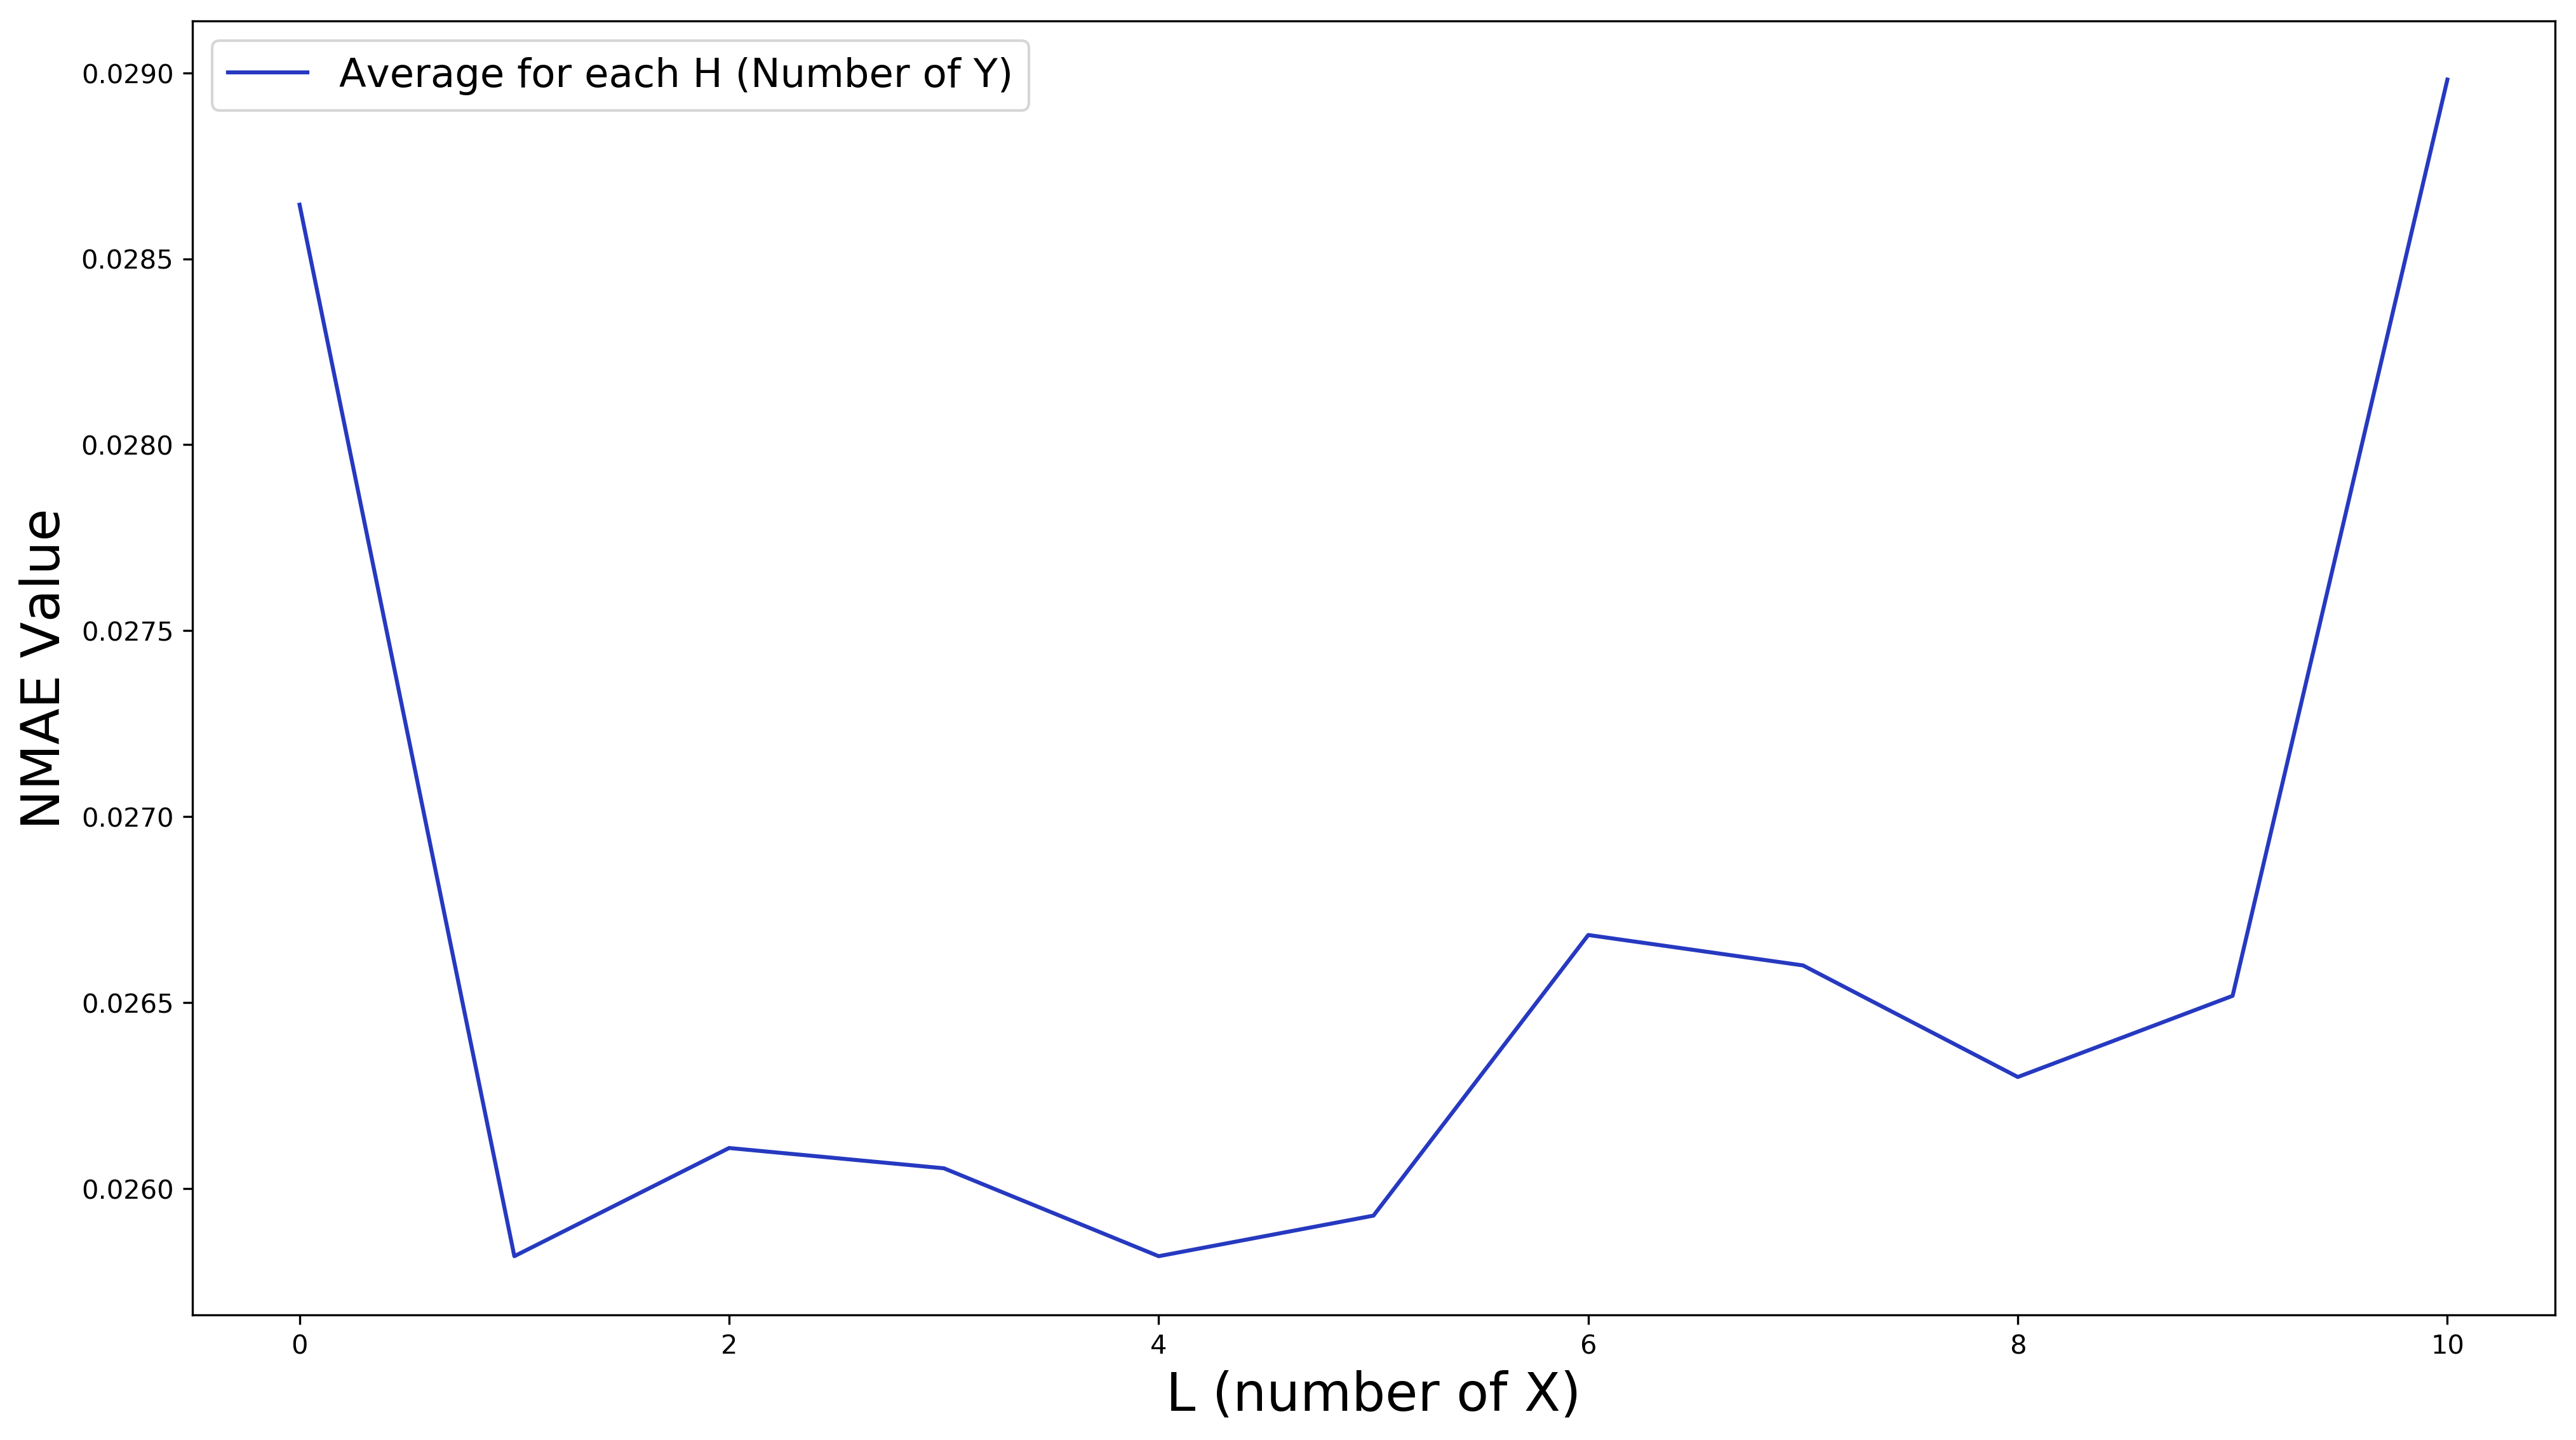

In [4]:
#plot for the RNN data, mean of H
data = RNN_Encoder_NMAE_table
plt_data = np.array(data)
#mean value on colounmns
plt_data = np.mean(plt_data, axis=0)
plt.figure(figsize=(16,9), dpi=300)
plt.plot(plt_data, color=(np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)))
plt.xlabel('L (number of X)', fontsize=20)
plt.ylabel('NMAE Value', fontsize=20)
plt.legend(['Average for each H (Number of Y)'], loc=2,fontsize=15)

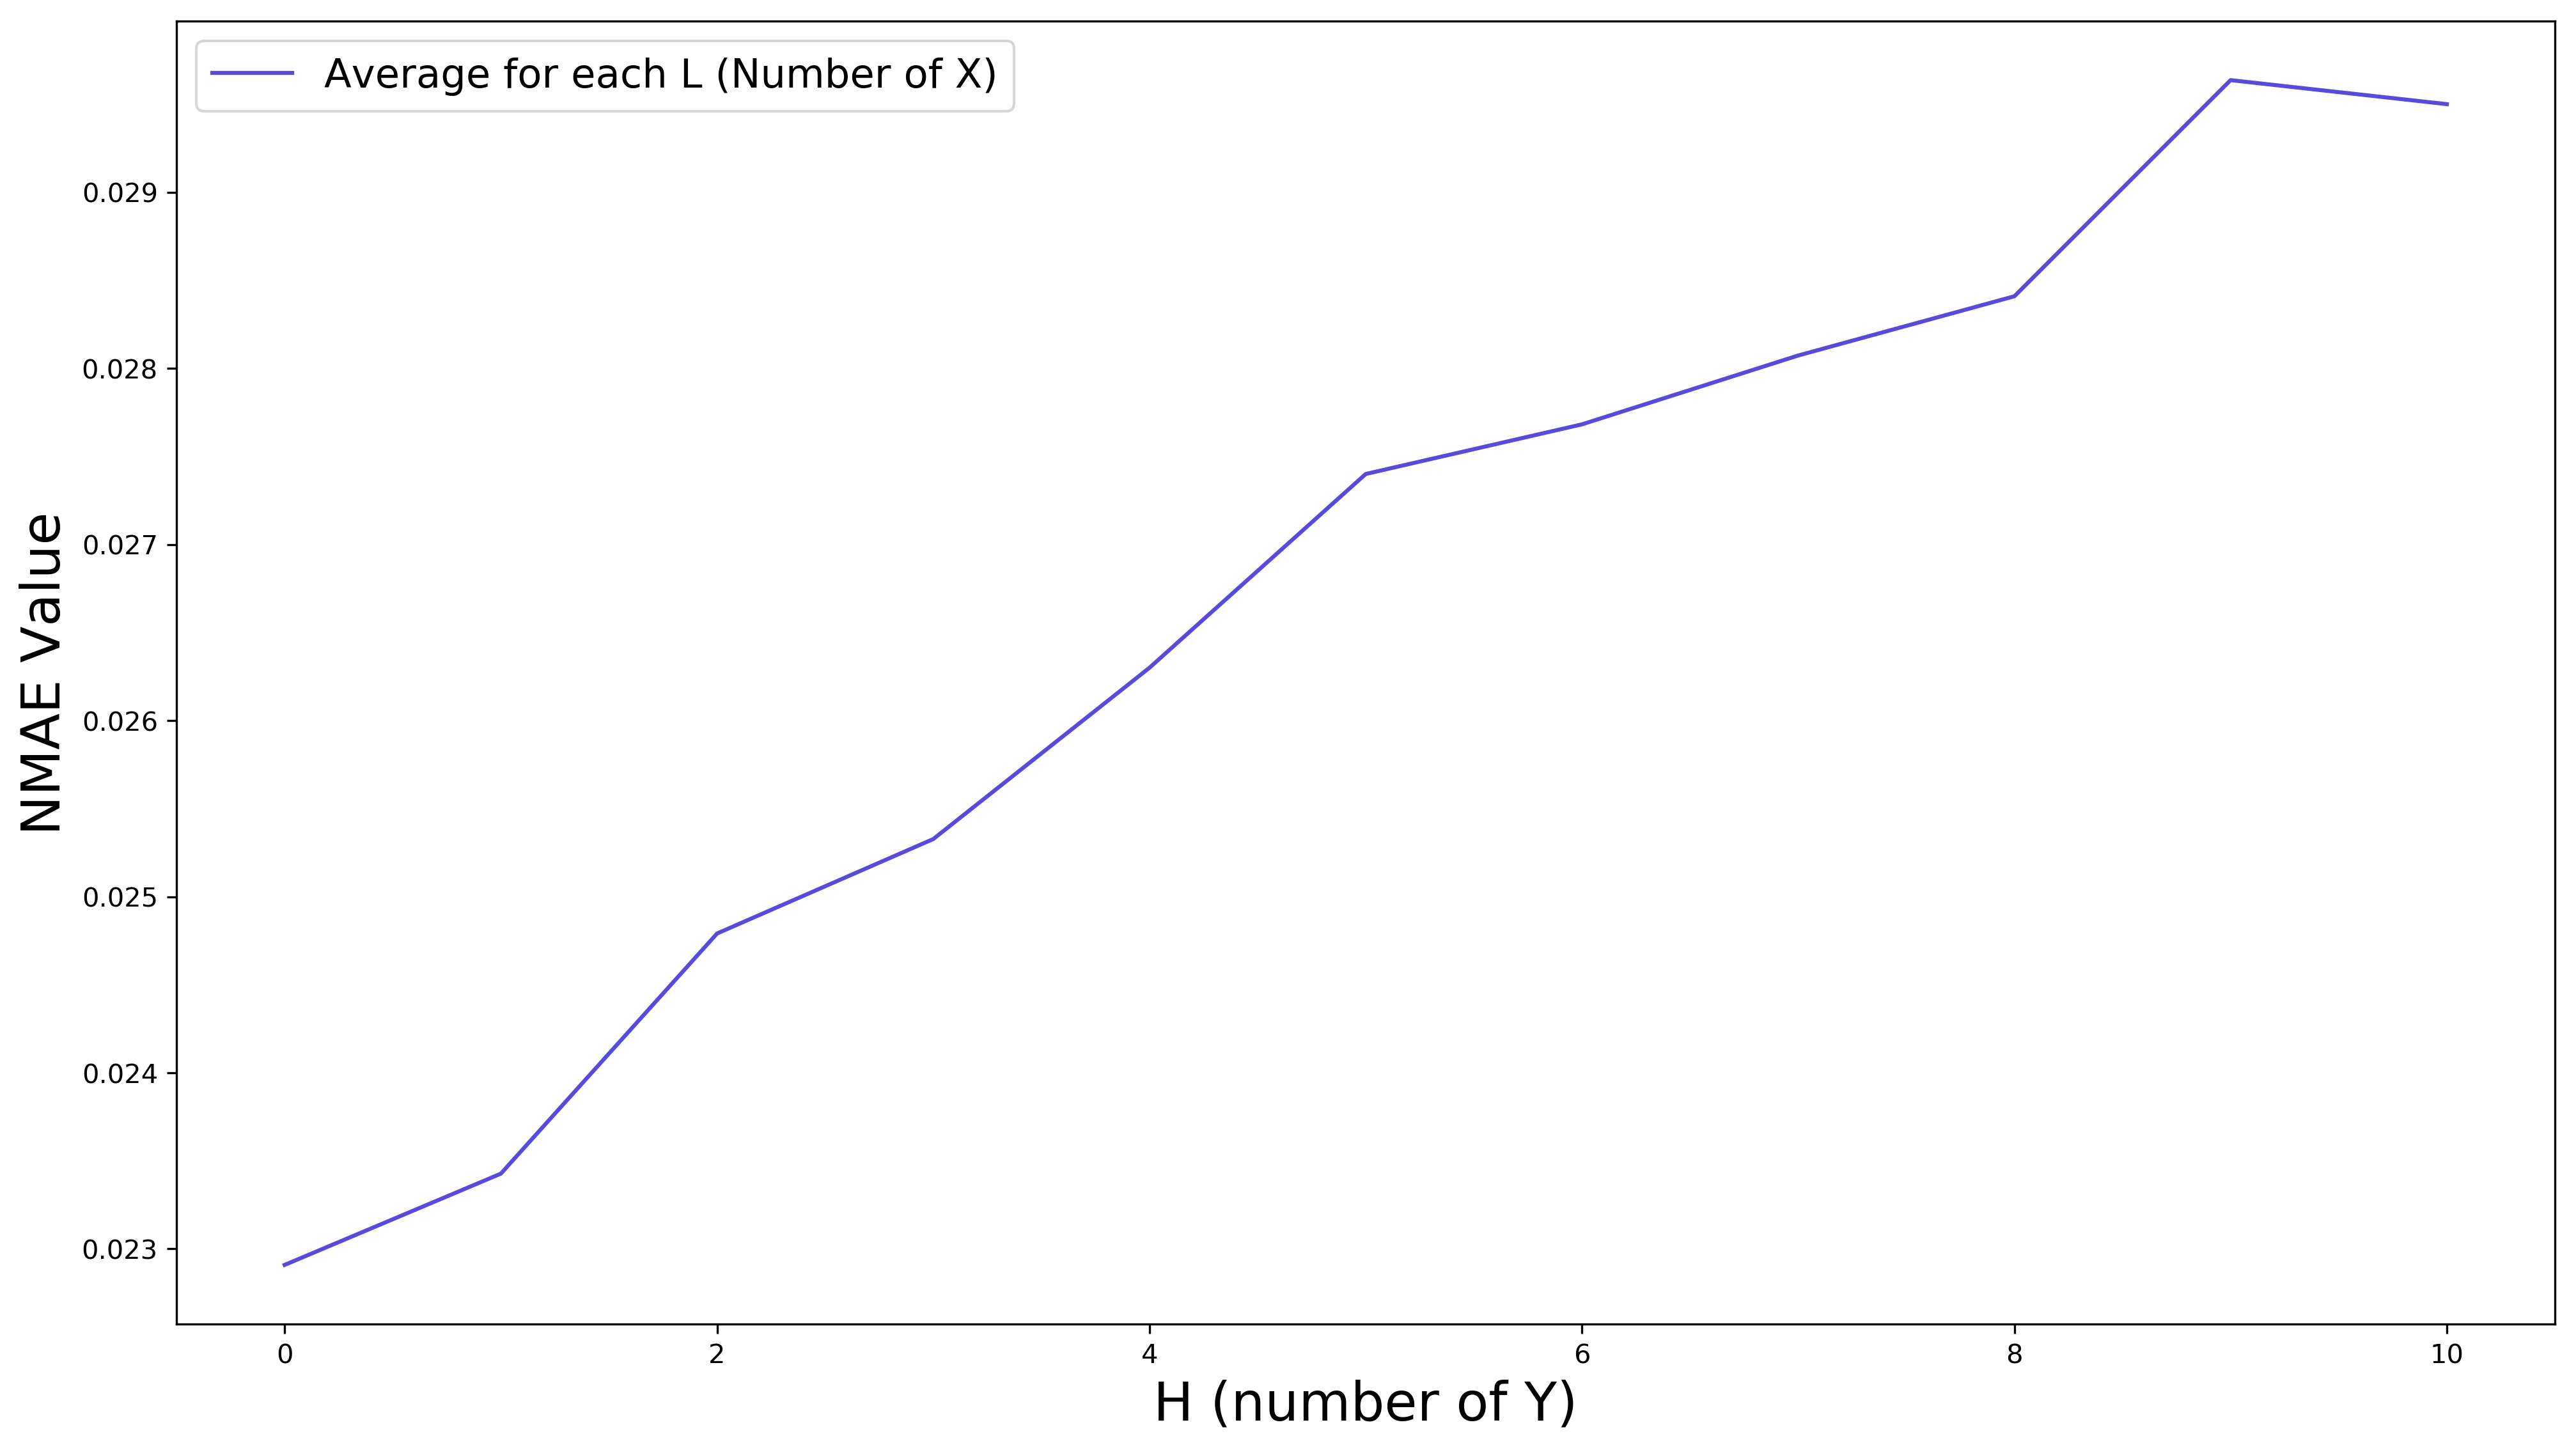

In [5]:
#plot for the RNN data, mean of L
data = RNN_Encoder_NMAE_table
plt_data = np.array(data)
#mean value on colounmns
plt_data = np.mean(plt_data, axis=1)
plt.figure(figsize=(16,9), dpi=300)
plt.plot(plt_data, color=(np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)))
plt.xlabel('H (number of Y)', fontsize=20)
plt.ylabel('NMAE Value', fontsize=20)
plt.legend(['Average for each L (Number of X)'], loc=2,fontsize=15)

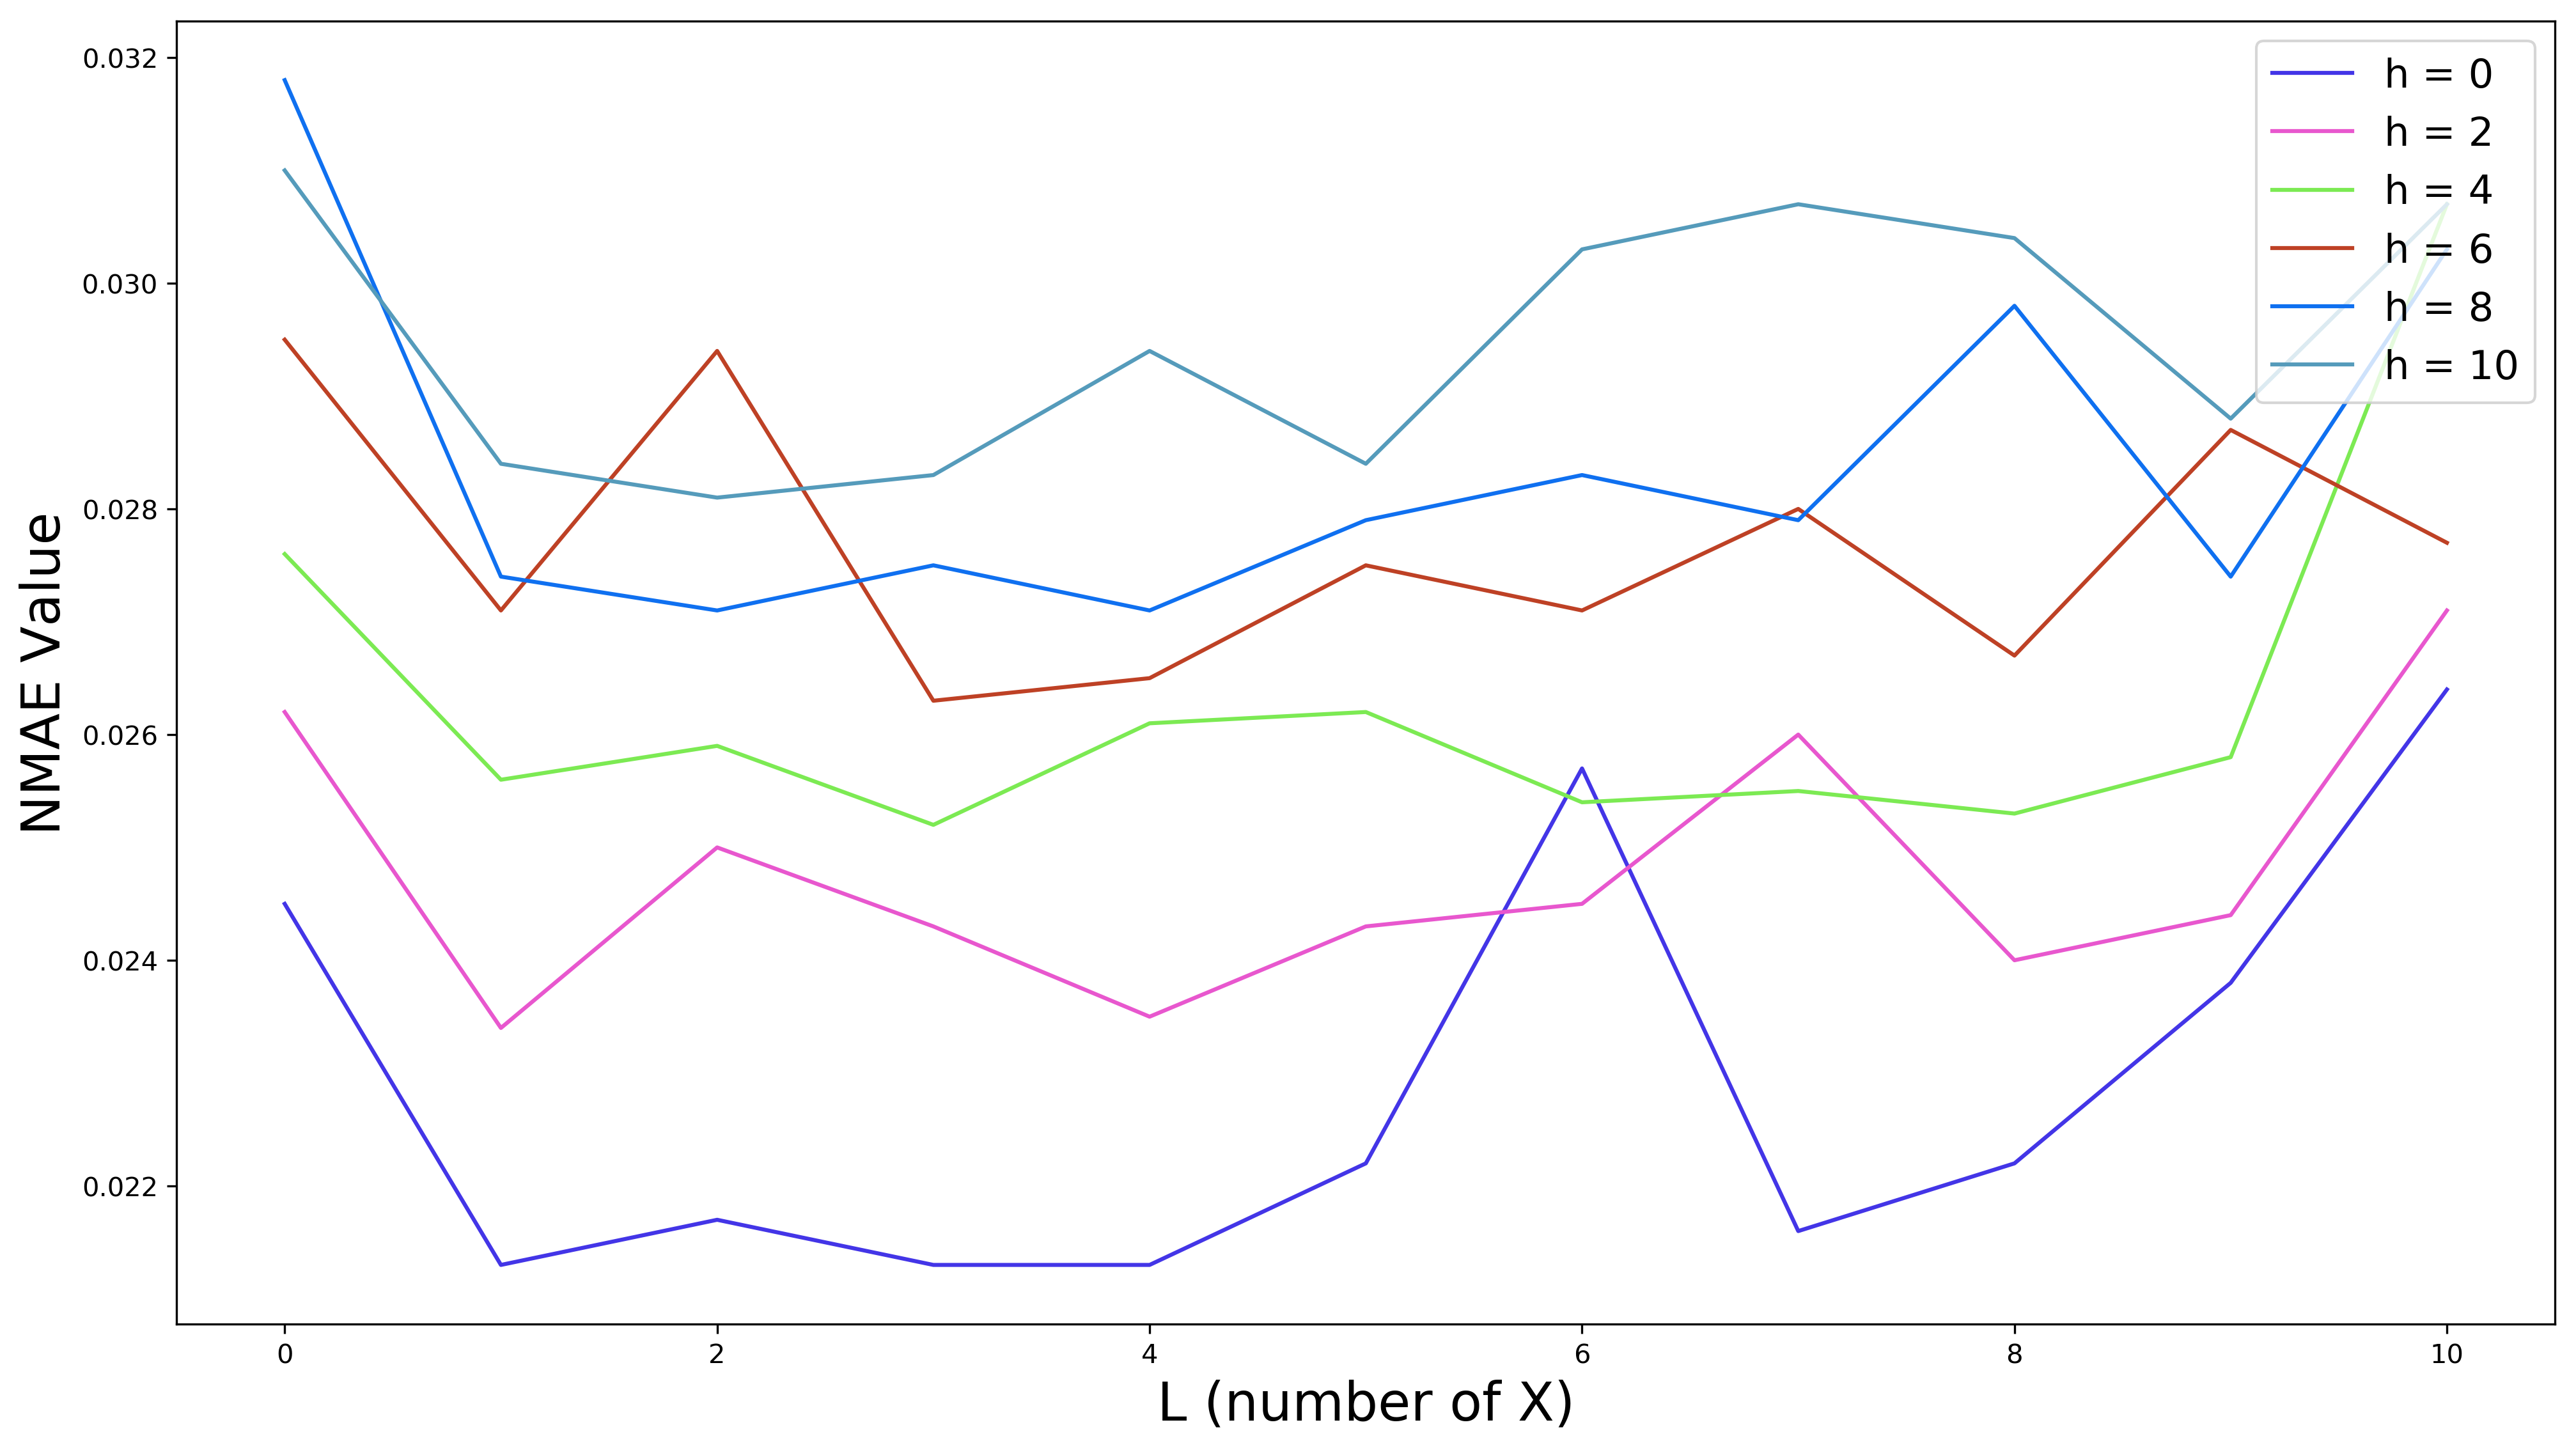

In [6]:
#plot for the RNN data, traverse on H
data = RNN_Encoder_NMAE_table
plt_data = np.array(data)
legend_list = []
plt.figure(figsize=(16,9), dpi=300)
for i in range(0,len(a),2):    
    plt.plot(plt_data[i], color=(np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)))
    legend_list.append("h = "+str(i))
# plt.plot(AR_pred, color = 'r')
plt.xlabel('L (number of X)', fontsize=20)
plt.ylabel('NMAE Value', fontsize=20)
plt.legend(legend_list, loc=1,fontsize=15)


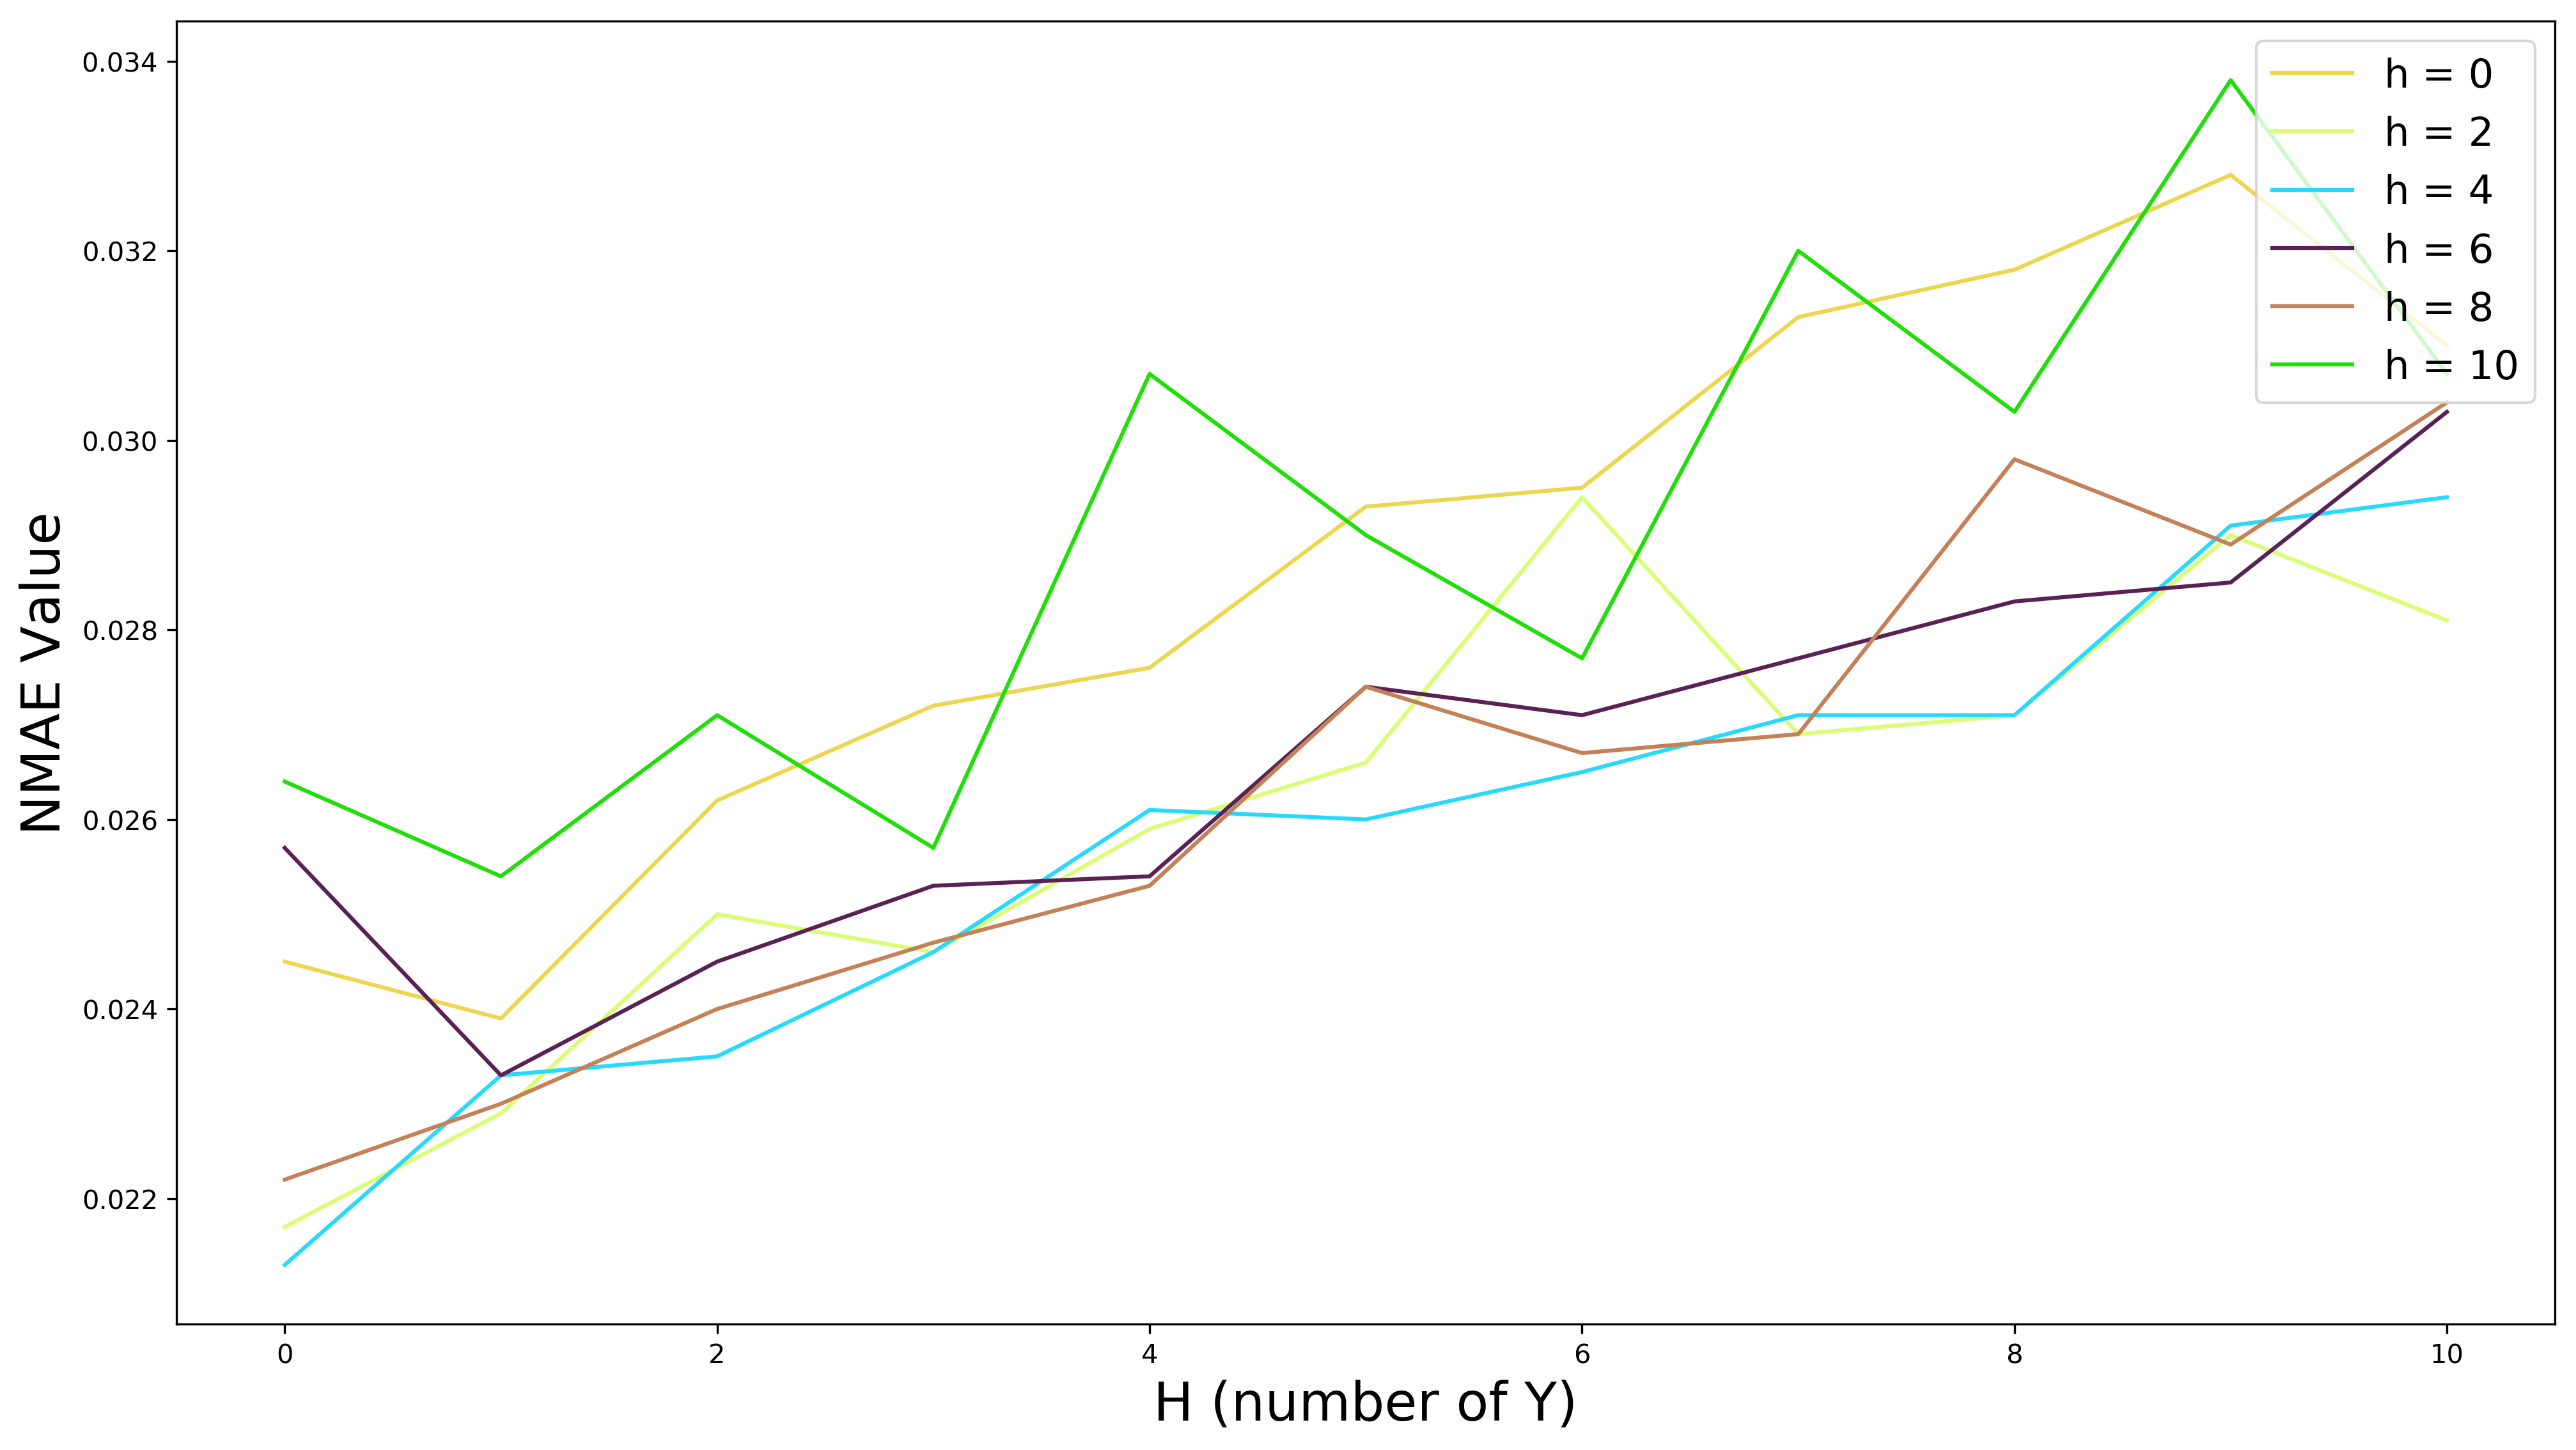

In [7]:
#plot for the RNN data, traverse on L
data = RNN_Encoder_NMAE_table
plt_data = np.array(data)
legend_list = []
plt.figure(figsize=(16,9), dpi=300)
for i in range(0,len(a),2):    
    plt.plot(plt_data[:,i], color=(np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)))
    legend_list.append("h = "+str(i))
# plt.plot(AR_pred, color = 'r')
plt.xlabel('H (number of Y)', fontsize=20)
plt.ylabel('NMAE Value', fontsize=20)
plt.legend(legend_list, loc=1,fontsize=15)

Text(0, 0.5, 'NMAE value')

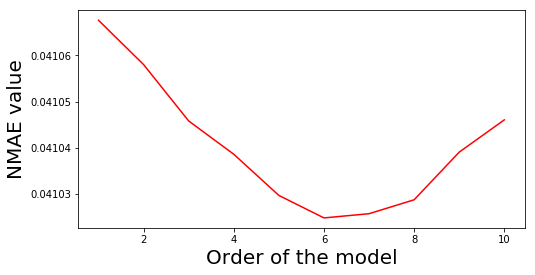

In [525]:
'''
Task 3
'''
# AR model
AR_history = Y_train.to_numpy()
AR_NMAE = []
x_axis = [i for i in range(1,11)]

# Order change from 1 to 10
for i in range(1, 11):
    AR_model = AR(AR_history)
    AR_model_fit = AR_model.fit(maxlag = i)
    AR_pred = AR_model_fit.predict(len(AR_history),len(AR_history)+len(Y_test_np)-1)
    AR_NMAE.append(CalculateNMAE(AR_pred, Y_test_np))
    
# Plot
plt.figure(num =1, figsize=(8,4))
plt.plot(x_axis,AR_NMAE, color = 'r')
plt.xlabel('Order of the model', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

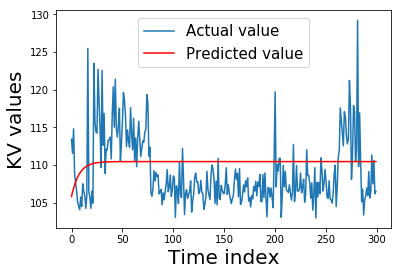

In [517]:
# AR model, plot the predicted and measured value for first 300 samples

AR_history = Y_train.to_numpy()
AR_pred = []
for i in range(300):
    AR_model = AR(AR_history)
    AR_model_fit = AR_model.fit(maxlag = 3)
    pred = AR_model_fit.predict(len(AR_history),len(AR_history))
    AR_history = np.append(AR_history,pred)
#     print(pred)
    AR_pred.append(pred)
plt.plot(Y_test_np[:300])
plt.plot(AR_pred, color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

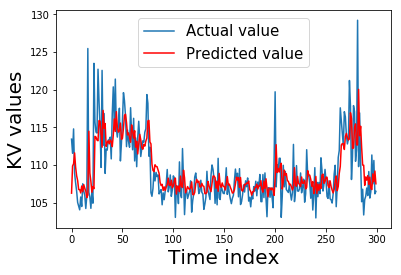

In [518]:
# Plot 300 samples for AR if we put the measured test value into the model

Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()

AR_model = AR(Y_train_np)
AR_NMAE_li = []
for i in range(1,11):
    AR_model_fit = AR_model.fit(maxlag = i)
    window = AR_model_fit.k_ar
    coef = AR_model_fit.params
    # walk forward over time steps in test
    AR_history = Y_train_np[len(Y_train_np)-window:]
    AR_history = [AR_history[i] for i in range(len(AR_history))]
    AR_predictions = list()
    for t in range(len(Y_test)):
        length = len(AR_history)
        lag = [AR_history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = Y_test_np[t]
        AR_predictions.append(yhat)
        AR_history.append(obs)
    AR_NMAE_li.append(CalculateNMAE(AR_predictions, Y_test_np))
plt.plot(Y_test_np[:300])
plt.plot(AR_predictions[:300], color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

Text(0, 0.5, 'NMAE value')

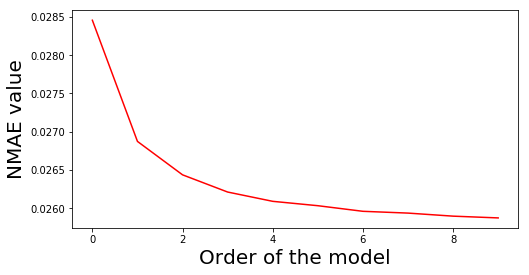

In [403]:
# NMAE for the model above

plt.figure(num =1, figsize=(8,4))
plt.plot(AR_NMAE_li, color = 'r')
plt.xlabel('Order of the model', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

In [526]:
# ARMA model and calculate the NMAE

ARMA_NMAE=[]
for i in range (1, 11):
    model = ARMA(Y_train_np, order=(1, i))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1)
    print(CalculateNMAE(yhat, Y_test_np))
    ARMA_NMAE.append(CalculateNMAE(yhat, Y_test_np))


0.04104079192763099
0.0410544567754157
0.04104817070240546
0.04104156553433927
0.04103837290069913
0.04103957732703066
0.04103859361145934
0.041043530922402795
0.041045126115802875
0.04104537728969509


Text(0, 0.5, 'NMAE value')

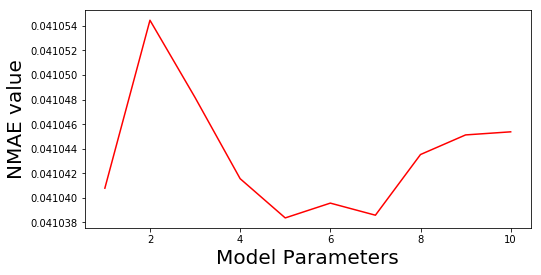

In [527]:


plt.figure(num = 1, figsize=(8,4))
plt.plot([i for i in range(1,11)], ARMA_NMAE, color = 'r')
plt.xlabel('Model Parameters', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

0.04104079192763099


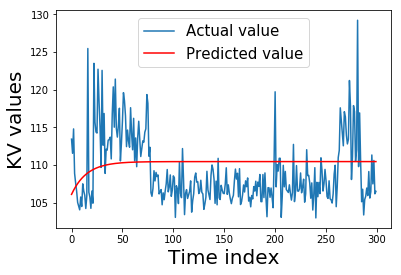

In [543]:
ARMA_NMAE_plot=[]
model_plot = ARMA(Y_train_np, order=(1, 1))
model_fit_plot = model_plot.fit(disp=False)
# make prediction
yhat_plot = model_fit_plot.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1)
print(CalculateNMAE(yhat_plot, Y_test_np))
ARMA_NMAE_plot.append(CalculateNMAE(yhat_plot, Y_test_np))

plt.plot(Y_test_np[:300])
plt.plot(yhat_plot[:300], color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

In [480]:
# for i in range (1, 11):
#     model = ARMA(Y_train_np, order=(1, i))
#     model_fit = model.fit(disp=False)
#     # make prediction
#     yhat = model_fit.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1)
#     print(CalculateNMAE(yhat, Y_test_np))

history = [x for x in Y_train_np]
predictions = list()
for t in range(50):
    model = ARMA(history, order=(3,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = Y_test_np[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=106.280010, expected=113.417800
predicted=109.733107, expected=111.537000
predicted=109.894003, expected=114.777800
predicted=111.401961, expected=108.867800
predicted=109.524249, expected=107.609500
predicted=108.621838, expected=106.515300
predicted=107.961193, expected=105.005100


KeyboardInterrupt: 

In [508]:
ARMA_NMAE=[]
test_len = int(len(Y_test_np)/4)
for i in range(1,11):
    ARMA_history = [x for x in Y_train_np]
    ARMA_predictions = list()
    for t in range(test_len):
        model = ARMA(ARMA_history, order=(1,i))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        ARMA_predictions.append(yhat)
        obs = Y_test_np[t]
        ARMA_history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
    ARMA_NMAE.append(CalculateNMAE(ARMA_predictions, Y_test_np[:test_len]))

predicted=106.569481, expected=113.417800
predicted=112.474921, expected=111.537000
predicted=111.189990, expected=114.777800
predicted=113.404193, expected=108.867800
predicted=109.366551, expected=107.609500
predicted=108.506860, expected=106.515300
predicted=107.759208, expected=105.005100
predicted=106.727234, expected=104.516200
predicted=106.392929, expected=104.028200
predicted=106.059169, expected=105.731700
predicted=107.222955, expected=104.470300
predicted=106.360791, expected=107.480400
predicted=108.417512, expected=106.519000
predicted=107.760479, expected=105.950600
predicted=107.371929, expected=104.206300
predicted=106.179720, expected=105.888200
predicted=107.328883, expected=125.458800
predicted=120.699709, expected=106.366600
predicted=107.658676, expected=105.736400
predicted=107.228261, expected=104.226500
predicted=106.197120, expected=106.525700
predicted=107.766778, expected=104.910500
predicted=106.663776, expected=123.488600
predicted=119.345633, expected=115

predicted=107.195056, expected=106.925600
predicted=108.034523, expected=105.702700
predicted=107.199142, expected=104.303900
predicted=106.243472, expected=110.704700
predicted=110.615245, expected=119.709300
predicted=116.765175, expected=107.078100
predicted=108.139238, expected=110.028300
predicted=110.153508, expected=109.176100
predicted=109.571645, expected=110.877600
predicted=110.733342, expected=110.875500
predicted=110.731919, expected=103.028100
predicted=105.374053, expected=105.830800
predicted=107.287482, expected=109.941700
predicted=110.094106, expected=107.082700
predicted=108.142177, expected=109.126200
predicted=109.537265, expected=106.723200
predicted=107.896627, expected=106.535900
predicted=107.768625, expected=106.331100
predicted=107.628661, expected=107.353500
predicted=108.326603, expected=106.241300
predicted=107.567116, expected=105.321800
predicted=106.939114, expected=106.325600
predicted=107.624351, expected=112.719900
predicted=111.990144, expected=105

predicted=105.905427, expected=130.377100
predicted=124.021548, expected=129.302400
predicted=123.293590, expected=119.754600
predicted=116.781388, expected=117.680400
predicted=115.367491, expected=112.611600
predicted=111.911427, expected=113.777900
predicted=112.706694, expected=114.184700
predicted=112.984171, expected=113.635100
predicted=112.609544, expected=109.096300
predicted=109.514978, expected=114.844300
predicted=113.433878, expected=115.261900
predicted=113.718776, expected=112.617200
predicted=111.915696, expected=113.892900
predicted=112.785540, expected=113.457500
predicted=112.488780, expected=116.039300
predicted=114.249269, expected=115.211300
predicted=113.684896, expected=110.051900
predicted=110.167124, expected=113.809300
predicted=112.728918, expected=132.160200
predicted=125.243725, expected=115.045000
predicted=113.570457, expected=111.826300
predicted=111.377090, expected=115.236500
predicted=113.701069, expected=112.067300
predicted=111.541456, expected=108

predicted=108.913071, expected=103.984900
predicted=106.038459, expected=105.852700
predicted=107.309195, expected=106.626300
predicted=107.835442, expected=108.701900
predicted=109.247674, expected=105.373500
predicted=106.982840, expected=111.326600
predicted=111.033402, expected=108.235100
predicted=108.930002, expected=109.423800
predicted=109.738731, expected=105.806100
predicted=107.277243, expected=109.814500
predicted=110.004441, expected=107.164700
predicted=108.201576, expected=104.604900
predicted=106.459744, expected=109.089100
predicted=109.510689, expected=107.727300
predicted=108.584128, expected=105.867500
predicted=107.318644, expected=108.069900
predicted=108.817038, expected=105.362200
predicted=106.974642, expected=106.721700
predicted=107.899513, expected=108.194000
predicted=108.901185, expected=113.129200
predicted=112.258964, expected=106.420500
predicted=107.694730, expected=112.813400
predicted=112.043890, expected=107.373900
predicted=108.343534, expected=106

predicted=109.769750, expected=106.779400
predicted=107.949471, expected=107.232100
predicted=108.256800, expected=106.625100
predicted=107.844471, expected=107.805500
predicted=108.646011, expected=111.533800
predicted=111.177873, expected=105.665800
predicted=107.193011, expected=107.699800
predicted=108.574179, expected=108.970900
predicted=109.437301, expected=105.191200
predicted=106.870491, expected=112.413700
predicted=111.774984, expected=107.900200
predicted=108.710265, expected=106.010200
predicted=107.426811, expected=108.854500
predicted=109.358093, expected=107.637000
predicted=108.531341, expected=108.209500
predicted=108.920014, expected=108.480400
predicted=109.103908, expected=107.360100
predicted=108.343135, expected=113.214600
predicted=112.318368, expected=113.124800
predicted=112.257469, expected=107.110100
predicted=108.173610, expected=105.984000
predicted=107.408875, expected=106.399200
predicted=107.690656, expected=107.294200
predicted=108.298262, expected=108

predicted=110.730873, expected=110.796200
predicted=110.691245, expected=117.454900
predicted=115.210537, expected=117.373500
predicted=115.155657, expected=120.268800
predicted=117.121655, expected=106.907200
predicted=108.052661, expected=104.311600
predicted=106.291034, expected=106.499500
predicted=107.775682, expected=106.736900
predicted=107.936669, expected=108.144100
predicted=108.891566, expected=111.578700
predicted=111.222334, expected=109.535700
predicted=109.835940, expected=105.887900
predicted=107.360427, expected=109.389700
predicted=109.736755, expected=109.304300
predicted=109.678773, expected=108.552700
predicted=109.168704, expected=105.995800
predicted=107.433472, expected=104.518400
predicted=106.430616, expected=104.844900
predicted=106.651957, expected=110.132500
predicted=110.240367, expected=106.592200
predicted=107.837805, expected=106.284600
predicted=107.628921, expected=106.331600
predicted=107.660682, expected=107.397400
predicted=108.383891, expected=111

predicted=108.564021, expected=105.198600
predicted=106.897641, expected=104.456000
predicted=106.394252, expected=108.906900
predicted=109.409807, expected=107.300100
predicted=108.321138, expected=105.834000
predicted=107.327697, expected=106.618800
predicted=107.859294, expected=108.181600
predicted=108.918064, expected=104.817500
predicted=106.638626, expected=106.277200
predicted=107.627505, expected=107.225900
predicted=108.270198, expected=106.817800
predicted=107.993581, expected=106.651600
predicted=107.880852, expected=107.123300
predicted=108.200359, expected=109.097600
predicted=109.538048, expected=104.730300
predicted=106.578762, expected=105.193200
predicted=106.892210, expected=108.957700
predicted=109.442973, expected=104.509700
predicted=106.428959, expected=104.395200
predicted=106.351097, expected=145.345100
predicted=134.082909, expected=109.303400
predicted=109.680207, expected=107.016800
predicted=108.135773, expected=107.698600
predicted=108.596187, expected=105

predicted=108.396126, expected=104.138400
predicted=106.197346, expected=105.747600
predicted=107.281239, expected=106.363600
predicted=107.696083, expected=103.701000
predicted=105.902038, expected=108.105000
predicted=108.868982, expected=106.770400
predicted=107.969800, expected=109.606600
predicted=109.880449, expected=106.609900
predicted=107.861598, expected=104.975800
predicted=106.760528, expected=105.902100
predicted=107.384419, expected=105.867900
predicted=107.361216, expected=104.385700
predicted=106.362347, expected=107.748000
predicted=108.627634, expected=108.709800
predicted=109.275579, expected=107.791900
predicted=108.657103, expected=105.323600
predicted=106.993951, expected=106.541400
predicted=107.814329, expected=107.952000
predicted=108.764661, expected=107.779900
predicted=108.648640, expected=108.059200
predicted=108.836758, expected=105.780100
predicted=107.301041, expected=107.787600
predicted=108.653579, expected=109.131300
predicted=109.558889, expected=107

predicted=114.933206, expected=113.607900
predicted=112.573404, expected=120.476800
predicted=117.200475, expected=112.427800
predicted=111.778750, expected=105.797500
predicted=107.313394, expected=108.832500
predicted=109.357317, expected=108.226500
predicted=108.949157, expected=109.454000
predicted=109.775790, expected=107.916800
predicted=108.740512, expected=109.320000
predicted=109.685468, expected=105.429400
predicted=107.065217, expected=104.168500
predicted=106.215746, expected=110.245300
predicted=110.308361, expected=107.131300
predicted=108.211219, expected=110.689000
predicted=110.607092, expected=108.709500
predicted=109.274029, expected=107.166000
predicted=108.234519, expected=105.772400
predicted=107.295863, expected=109.429600
predicted=109.758759, expected=108.709900
predicted=109.274056, expected=110.420900
predicted=110.426282, expected=112.078300
predicted=111.542440, expected=108.853500
predicted=109.370784, expected=104.749800
predicted=106.607111, expected=109

predicted=117.131156, expected=120.893200
predicted=117.466629, expected=115.840200
predicted=114.069552, expected=120.815800
predicted=117.415322, expected=119.910600
predicted=116.807423, expected=119.477200
predicted=116.516659, expected=119.195700
predicted=116.327974, expected=114.141500
predicted=112.929163, expected=120.282400
predicted=117.059181, expected=116.097000
predicted=114.244615, expected=117.455800
predicted=115.158747, expected=111.037600
predicted=110.842527, expected=108.953900
predicted=109.441342, expected=114.915100
predicted=113.449887, expected=105.669900
predicted=107.233456, expected=110.942300
predicted=110.778358, expected=106.756200
predicted=107.963904, expected=106.040800
predicted=107.482779, expected=105.763400
predicted=107.296105, expected=105.727400
predicted=107.271730, expected=106.742100
predicted=107.953876, expected=106.795300
predicted=107.989536, expected=104.945400
predicted=106.745484, expected=113.493100
predicted=112.492727, expected=110

predicted=108.217634, expected=105.246300
predicted=106.939211, expected=105.552100
predicted=107.144707, expected=105.845900
predicted=107.342154, expected=107.242800
predicted=108.281610, expected=108.848100
predicted=109.361276, expected=107.880600
predicted=108.710494, expected=104.644400
predicted=106.533651, expected=105.824000
predicted=107.326918, expected=105.915500
predicted=107.388310, expected=109.124300
predicted=109.546607, expected=106.296000
predicted=107.644155, expected=109.429100
predicted=109.751517, expected=108.461500
predicted=109.100662, expected=106.469800
predicted=107.760918, expected=107.076300
predicted=108.168771, expected=106.768700
predicted=107.961763, expected=106.946500
predicted=108.081260, expected=107.269200
predicted=108.298235, expected=108.560600
predicted=109.166843, expected=108.786100
predicted=109.318486, expected=105.368900
predicted=107.019778, expected=109.059800
predicted=109.502464, expected=106.326400
predicted=107.663775, expected=107

predicted=111.217305, expected=112.725700
predicted=111.974463, expected=102.804200
predicted=105.311215, expected=108.916000
predicted=109.415774, expected=105.656300
predicted=107.226671, expected=108.069200
predicted=108.846975, expected=108.787300
predicted=109.329161, expected=105.880000
predicted=107.376695, expected=106.807600
predicted=107.999520, expected=107.693000
predicted=108.594036, expected=107.643500
predicted=108.560721, expected=112.181600
predicted=111.608266, expected=104.925900
predicted=106.735879, expected=107.305600
predicted=108.333810, expected=107.972700
predicted=108.781711, expected=106.508800
predicted=107.798576, expected=106.428900
predicted=107.744800, expected=105.249100
predicted=106.952333, expected=107.546100
predicted=108.494813, expected=107.471700
predicted=108.444776, expected=108.710500
predicted=109.276646, expected=105.991800
predicted=107.450795, expected=104.248700
predicted=106.279920, expected=105.956700
predicted=107.426862, expected=108

predicted=111.390668, expected=111.080800
predicted=110.865362, expected=117.177300
predicted=114.952066, expected=104.561000
predicted=106.495858, expected=112.282400
predicted=111.670507, expected=106.741900
predicted=107.957716, expected=108.407600
predicted=109.073863, expected=107.485500
predicted=108.455890, expected=114.894200
predicted=113.420405, expected=105.962500
predicted=107.435765, expected=105.743300
predicted=107.288736, expected=106.556600
predicted=107.833558, expected=108.995400
predicted=109.467591, expected=107.721100
predicted=108.613724, expected=109.625100
predicted=109.889431, expected=102.972400
predicted=105.431785, expected=106.992600
predicted=108.125430, expected=104.730800
predicted=106.609772, expected=105.709900
predicted=107.265652, expected=106.184700
predicted=107.583655, expected=106.295900
predicted=107.658036, expected=108.233500
predicted=108.956298, expected=109.228600
predicted=109.623043, expected=104.354500
predicted=106.356957, expected=108

predicted=113.573746, expected=123.157200
predicted=118.921074, expected=103.841300
predicted=106.038455, expected=107.171800
predicted=108.258884, expected=106.745500
predicted=107.974566, expected=105.279400
predicted=106.996920, expected=122.272800
predicted=118.325202, expected=110.955000
predicted=110.781026, expected=114.767500
predicted=113.321813, expected=113.606500
predicted=112.548181, expected=118.168600
predicted=115.588845, expected=116.353000
predicted=114.379030, expected=113.795800
predicted=112.674812, expected=114.301900
predicted=113.012223, expected=116.271200
predicted=114.324944, expected=118.593700
predicted=115.873398, expected=111.934200
predicted=111.434578, expected=115.479000
predicted=113.797247, expected=113.417500
predicted=112.423342, expected=115.389400
predicted=113.737757, expected=114.542000
predicted=113.173084, expected=111.614500
predicted=111.221906, expected=115.972200
predicted=114.126446, expected=110.053200
predicted=110.181433, expected=119

predicted=113.392987, expected=123.187200
predicted=118.936783, expected=116.852400
predicted=114.716764, expected=115.659900
predicted=113.922616, expected=112.146300
predicted=111.582220, expected=107.061500
predicted=108.195307, expected=117.408700
predicted=115.086983, expected=120.885800
predicted=117.403753, expected=114.642300
predicted=113.244920, expected=113.902300
predicted=112.752145, expected=119.404600
predicted=116.417438, expected=106.996500
predicted=108.153133, expected=105.096200
predicted=106.887463, expected=108.196800
predicted=108.952271, expected=110.374200
predicted=110.402266, expected=108.976200
predicted=109.471272, expected=108.565600
predicted=109.197801, expected=107.087200
predicted=108.213201, expected=105.788000
predicted=107.347853, expected=103.922100
predicted=106.104932, expected=106.915800
predicted=108.098635, expected=108.768600
predicted=109.332515, expected=110.333900
predicted=110.374944, expected=105.431300
predicted=107.109896, expected=108

predicted=116.705831, expected=105.997800
predicted=107.489239, expected=111.462300
predicted=111.122415, expected=111.204500
predicted=110.951036, expected=107.935600
predicted=108.777702, expected=105.423100
predicted=107.107126, expected=107.347400
predicted=108.386439, expected=107.581400
predicted=108.541944, expected=106.998100
predicted=108.154037, expected=106.493700
predicted=107.818561, expected=106.907900
predicted=108.093858, expected=109.502800
predicted=109.819134, expected=107.691100
predicted=108.614527, expected=106.808900
predicted=108.027869, expected=108.821900
predicted=109.366253, expected=108.688100
predicted=109.277254, expected=108.256000
predicted=108.989906, expected=106.343700
predicted=107.718326, expected=110.838900
predicted=110.707148, expected=108.424000
predicted=109.101519, expected=107.405400
predicted=108.424206, expected=107.210700
predicted=108.294668, expected=106.457100
predicted=107.793491, expected=105.922000
predicted=107.437553, expected=105

predicted=110.278508, expected=105.817500
predicted=107.371815, expected=107.840500
predicted=108.716370, expected=107.292100
predicted=108.351791, expected=107.643400
predicted=108.585216, expected=106.185700
predicted=107.616203, expected=110.640000
predicted=110.576856, expected=103.167800
predicted=105.610331, expected=105.946600
predicted=107.457182, expected=107.964400
predicted=108.798260, expected=106.248700
predicted=107.657806, expected=107.261200
predicted=108.330690, expected=106.481600
predicted=107.812406, expected=106.024400
predicted=107.508376, expected=106.825000
predicted=108.040425, expected=107.856400
predicted=108.725922, expected=107.389900
predicted=108.415768, expected=107.312300
predicted=108.364105, expected=106.449900
predicted=107.790748, expected=108.253900
predicted=108.989842, expected=106.147100
predicted=107.589310, expected=106.315300
predicted=107.700991, expected=109.165400
predicted=109.595510, expected=105.383300
predicted=107.081347, expected=106

predicted=107.952453, expected=110.533000
predicted=110.499509, expected=107.205500
predicted=108.296345, expected=106.921500
predicted=108.108211, expected=105.512500
predicted=107.175140, expected=106.166500
predicted=107.608040, expected=110.080500
predicted=110.199582, expected=105.120400
predicted=106.915363, expected=107.898000
predicted=108.754403, expected=106.472800
predicted=107.810662, expected=113.061500
predicted=112.173044, expected=108.169000
predicted=108.933863, expected=108.223200
predicted=108.969693, expected=109.434600
predicted=109.771688, expected=107.142700
predicted=108.254250, expected=106.086500
predicted=107.554841, expected=109.908700
predicted=110.085407, expected=104.635200
predicted=106.593932, expected=102.850400
predicted=105.411848, expected=106.555800
predicted=107.865159, expected=109.055300
predicted=109.520011, expected=108.908300
predicted=109.422654, expected=105.957100
predicted=107.468612, expected=105.545900
predicted=107.196190, expected=104

predicted=117.739135, expected=115.354300
predicted=113.685456, expected=114.905800
predicted=113.389051, expected=109.697400
predicted=109.945285, expected=106.287700
predicted=107.690804, expected=111.066200
predicted=110.850208, expected=107.909100
predicted=108.762859, expected=108.336200
predicted=109.045189, expected=108.118100
predicted=108.900940, expected=105.052100
predicted=106.873668, expected=105.095900
predicted=106.902431, expected=105.401100
predicted=107.104053, expected=106.719300
predicted=107.975554, expected=106.840300
predicted=108.055463, expected=106.105900
predicted=107.569732, expected=106.520900
predicted=107.844029, expected=105.356600
predicted=107.073977, expected=106.042300
predicted=107.527266, expected=108.197800
predicted=108.952563, expected=104.480400
predicted=106.494221, expected=106.012400
predicted=107.507168, expected=104.122100
predicted=106.256878, expected=106.122600
predicted=107.579709, expected=106.378300
predicted=107.748687, expected=104

predicted=113.456319, expected=119.478300
predicted=116.301361, expected=116.502800
predicted=114.371239, expected=119.237800
predicted=116.146116, expected=113.705600
predicted=112.556924, expected=117.661600
predicted=115.123674, expected=120.559200
predicted=117.004415, expected=117.173100
predicted=114.807564, expected=116.732400
predicted=114.521888, expected=122.762300
predicted=118.435764, expected=113.483900
predicted=112.414344, expected=114.884900
predicted=113.323519, expected=117.305400
predicted=114.894413, expected=114.619500
predicted=113.151649, expected=120.453300
predicted=116.937808, expected=114.140700
predicted=112.841258, expected=118.128400
predicted=115.429226, expected=120.719300
predicted=117.111428, expected=115.131400
predicted=113.484885, expected=120.864700
predicted=117.206346, expected=116.030900
predicted=114.069156, expected=112.403200
predicted=111.714822, expected=106.060200
predicted=107.598370, expected=106.616100
predicted=107.959021, expected=104

predicted=108.208952, expected=111.033500
predicted=110.838047, expected=114.656900
predicted=113.198113, expected=107.141000
predicted=108.302956, expected=107.485400
predicted=108.527182, expected=107.545400
predicted=108.566184, expected=109.825600
predicted=110.051234, expected=106.228300
predicted=107.708291, expected=106.052800
predicted=107.593849, expected=107.452000
predicted=108.505076, expected=106.209700
predicted=107.695838, expected=108.342300
predicted=109.084785, expected=109.037600
predicted=109.537605, expected=105.065200
predicted=106.950209, expected=109.078700
predicted=109.564249, expected=106.561900
predicted=107.924969, expected=109.167800
predicted=109.622177, expected=106.347400
predicted=107.785161, expected=106.647300
predicted=107.980379, expected=107.906400
predicted=108.800387, expected=109.648800
predicted=109.935213, expected=110.013600
predicted=110.172799, expected=106.397400
predicted=107.817461, expected=111.134600
predicted=110.902832, expected=108

predicted=108.614040, expected=106.928200
predicted=108.170966, expected=106.198100
predicted=107.695492, expected=107.773800
predicted=108.721333, expected=109.686700
predicted=109.966758, expected=110.243800
predicted=110.329459, expected=109.829200
predicted=110.059517, expected=107.638900
predicted=108.633420, expected=107.556600
predicted=108.579765, expected=108.034800
predicted=108.891053, expected=106.874300
predicted=108.135378, expected=109.693000
predicted=109.970585, expected=108.263700
predicted=109.039953, expected=108.441900
predicted=109.155929, expected=105.093400
predicted=106.975605, expected=108.056000
predicted=108.904513, expected=106.668600
predicted=108.001089, expected=104.665400
predicted=106.696580, expected=105.273900
predicted=107.092610, expected=107.336000
predicted=108.435246, expected=108.467400
predicted=109.171892, expected=108.911300
predicted=109.460894, expected=103.369600
predicted=105.852293, expected=111.340600
predicted=111.042512, expected=107

predicted=109.167848, expected=105.349400
predicted=107.142348, expected=106.864400
predicted=108.128588, expected=106.835500
predicted=108.109672, expected=107.334600
predicted=108.434533, expected=106.622800
predicted=107.971004, expected=108.526400
predicted=109.210330, expected=109.186900
predicted=109.640329, expected=110.746000
predicted=110.655395, expected=109.367600
predicted=109.757961, expected=111.521600
predicted=111.160346, expected=108.643200
predicted=109.286336, expected=108.929600
predicted=109.472764, expected=105.965200
predicted=107.542671, expected=108.389100
predicted=109.120735, expected=106.427800
predicted=107.843718, expected=107.151900
predicted=108.315071, expected=106.243400
predicted=107.723448, expected=106.352900
predicted=107.794623, expected=107.308500
predicted=108.416721, expected=109.915800
predicted=110.114298, expected=107.277200
predicted=108.396289, expected=104.981100
predicted=106.901132, expected=106.551000
predicted=107.923206, expected=107

predicted=116.892408, expected=114.391900
predicted=113.028419, expected=116.091500
predicted=114.134175, expected=113.871200
predicted=112.689944, expected=131.479700
predicted=124.146619, expected=117.569600
predicted=115.095418, expected=118.466900
predicted=115.679453, expected=118.979000
predicted=116.013047, expected=117.032900
predicted=114.747422, expected=117.757500
predicted=115.219115, expected=115.635100
predicted=113.838628, expected=113.976000
predicted=112.759455, expected=110.999300
predicted=110.823114, expected=116.868200
predicted=114.640938, expected=103.338000
predicted=105.840272, expected=162.507800
predicted=144.290570, expected=125.078300
predicted=119.948480, expected=141.021200
predicted=130.297315, expected=130.273200
predicted=123.326139, expected=142.088600
predicted=131.009185, expected=118.142300
predicted=115.457965, expected=115.012500
predicted=113.428106, expected=115.771400
predicted=113.920501, expected=120.929900
predicted=117.267062, expected=115

predicted=108.022027, expected=106.704900
predicted=108.034562, expected=109.924200
predicted=110.121131, expected=108.231900
predicted=109.024244, expected=106.100600
predicted=107.642746, expected=104.032300
predicted=106.301902, expected=106.828800
predicted=108.114460, expected=113.690000
predicted=112.561610, expected=118.211400
predicted=115.492447, expected=112.810000
predicted=111.991433, expected=113.872700
predicted=112.680292, expected=111.628800
predicted=111.225954, expected=116.186600
predicted=114.180164, expected=112.663800
predicted=111.896912, expected=115.435800
predicted=113.693672, expected=112.684800
predicted=111.910670, expected=111.270500
predicted=110.994033, expected=114.471300
predicted=113.068654, expected=116.077300
predicted=114.109767, expected=113.446100
predicted=112.404391, expected=114.608500
predicted=113.157917, expected=112.111300
predicted=111.539364, expected=115.759600
predicted=113.904162, expected=118.565400
predicted=115.723236, expected=114

predicted=108.635791, expected=109.181300
predicted=109.651787, expected=110.162400
predicted=110.287424, expected=111.756500
predicted=111.320235, expected=108.981300
predicted=109.522207, expected=108.493600
predicted=109.206193, expected=107.304600
predicted=108.435781, expected=104.996900
predicted=106.940451, expected=106.798700
predicted=108.107771, expected=105.987700
predicted=107.582178, expected=110.118800
predicted=110.258791, expected=105.716300
predicted=107.406307, expected=104.987100
predicted=106.933651, expected=105.959200
predicted=107.563369, expected=106.119500
predicted=107.667103, expected=106.021700
predicted=107.603597, expected=107.092900
predicted=108.297606, expected=110.614600
predicted=110.579507, expected=106.434000
predicted=107.870646, expected=106.313600
predicted=107.792513, expected=105.229800
predicted=107.090074, expected=110.808900
predicted=110.705148, expected=106.508700
predicted=107.918820, expected=108.526100
predicted=109.225933, expected=111

predicted=107.401088, expected=103.068600
predicted=105.684646, expected=103.057200
predicted=105.676894, expected=103.364400
predicted=105.875640, expected=106.745300
predicted=108.066520, expected=105.170400
predicted=107.045765, expected=115.592700
predicted=113.799520, expected=107.520900
predicted=108.569366, expected=108.885000
predicted=109.453160, expected=110.323800
predicted=110.385377, expected=107.149400
predicted=108.328575, expected=108.524000
predicted=109.219164, expected=107.093300
predicted=108.292109, expected=106.983400
predicted=108.220813, expected=107.462800
predicted=108.531359, expected=104.976200
predicted=106.920021, expected=103.859200
predicted=106.195970, expected=107.290100
predicted=108.419071, expected=105.816200
predicted=107.463894, expected=107.533700
predicted=108.576734, expected=106.151900
predicted=107.681235, expected=107.479500
predicted=108.541438, expected=110.075300
predicted=110.223473, expected=105.764900
predicted=107.430324, expected=107

predicted=106.785456, expected=106.191400
predicted=107.704233, expected=106.526400
predicted=107.921063, expected=103.980700
predicted=106.272271, expected=106.211000
predicted=107.716515, expected=107.193600
predicted=108.352767, expected=106.142500
predicted=107.671947, expected=105.742200
predicted=107.412562, expected=103.719000
predicted=106.101992, expected=102.755000
predicted=105.477250, expected=115.029100
predicted=113.426529, expected=118.327500
predicted=115.562884, expected=110.545600
predicted=110.523300, expected=123.152500
predicted=118.687061, expected=116.297000
predicted=114.247663, expected=114.493100
predicted=113.079725, expected=120.971800
predicted=117.275388, expected=110.950400
predicted=110.786003, expected=121.177300
predicted=117.407666, expected=108.940200
predicted=109.484877, expected=118.771600
predicted=115.848887, expected=117.045200
predicted=114.731618, expected=114.348000
predicted=112.985750, expected=114.869100
predicted=113.323192, expected=113

predicted=117.207307, expected=107.569600
predicted=108.607264, expected=106.183800
predicted=107.711414, expected=107.796800
predicted=108.753960, expected=105.089400
predicted=107.003800, expected=104.291100
predicted=106.487543, expected=105.664100
predicted=107.374928, expected=104.596300
predicted=106.684461, expected=103.398600
predicted=105.909890, expected=106.502200
predicted=107.916200, expected=105.691200
predicted=107.391772, expected=107.698400
predicted=108.689317, expected=108.338400
predicted=109.103011, expected=105.120000
predicted=107.022251, expected=107.578800
predicted=108.611778, expected=105.521900
predicted=107.281881, expected=103.787800
predicted=106.160504, expected=105.889600
predicted=107.519253, expected=105.726300
predicted=107.413529, expected=107.356100
predicted=108.467185, expected=107.471700
predicted=108.541854, expected=107.235000
predicted=108.388738, expected=105.243400
predicted=107.100910, expected=107.036400
predicted=108.260118, expected=104

predicted=118.622550, expected=116.624100
predicted=114.451080, expected=124.601100
predicted=119.611410, expected=121.375700
predicted=117.525833, expected=120.647800
predicted=117.055701, expected=117.713500
predicted=115.157756, expected=124.492800
predicted=119.544911, expected=120.743400
predicted=117.119512, expected=119.281700
predicted=116.174215, expected=117.589400
predicted=115.079468, expected=120.009500
predicted=116.646116, expected=115.851200
predicted=113.955221, expected=118.487500
predicted=115.661640, expected=117.703700
predicted=115.154712, expected=120.378600
predicted=116.886570, expected=117.675300
predicted=115.137129, expected=117.480500
predicted=115.011350, expected=120.002200
predicted=116.644225, expected=118.048500
predicted=115.379852, expected=122.933600
predicted=118.543441, expected=106.351600
predicted=107.808756, expected=109.420500
predicted=109.794926, expected=107.336200
predicted=108.445927, expected=104.217600
predicted=106.427360, expected=109

In [507]:
# ARIMA_NMAE = []
# for i in range(1,11):
history = [x for x in Y_train_np]
predictions = list()
for t in range(30):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = Y_test_np[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
print(CalculateNMAE(predictions,Y_test_np[:30]))

predicted=105.592950, expected=113.417800
predicted=109.355793, expected=111.537000
predicted=109.836783, expected=114.777800
predicted=111.390297, expected=108.867800
predicted=109.620859, expected=107.609500
predicted=108.843171, expected=106.515300
predicted=108.700103, expected=105.005100
predicted=107.271652, expected=104.516200
predicted=106.602081, expected=104.028200
predicted=105.229811, expected=105.731700
predicted=105.575647, expected=104.470300
predicted=104.926862, expected=107.480400
predicted=106.068524, expected=106.519000
predicted=105.987827, expected=105.950600
predicted=105.839964, expected=104.206300
predicted=105.149952, expected=105.888200
predicted=105.594028, expected=125.458800
predicted=115.264815, expected=106.366600
predicted=109.253173, expected=105.736400
predicted=107.775370, expected=104.226500
predicted=106.214495, expected=106.525700
predicted=107.297545, expected=104.910500
predicted=107.857590, expected=123.488600
predicted=114.082427, expected=115

In [534]:
ARIMA_NMAE=[]
for i in range(1,11):
    model = ARIMA(Y_train_np, order=(i,1,i))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(len(Y_test_np))[0]
    print(CalculateNMAE(output, Y_test_np))
    ARIMA_NMAE.append(CalculateNMAE(output, Y_test_np))

0.045900949963709026
0.044583472672997185
0.0450726848190927
0.04464078026803061
0.04505174071500897
0.04478680823175071


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.044426865348396155


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.04522049226962056


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.04186655805447044
0.0461346931010413


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0, 0.5, 'NMAE value')

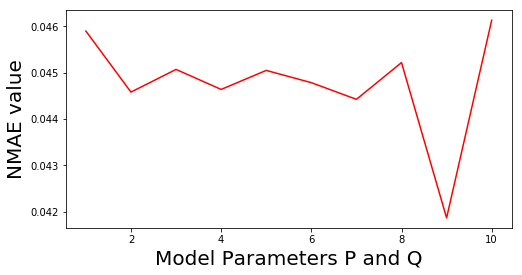

In [544]:
plt.figure(num = 1, figsize=(8,4))
plt.plot([i for i in range(1,11)], ARIMA_NMAE, color = 'r')
plt.xlabel('Model Parameters P and Q', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

0.045900949963709026


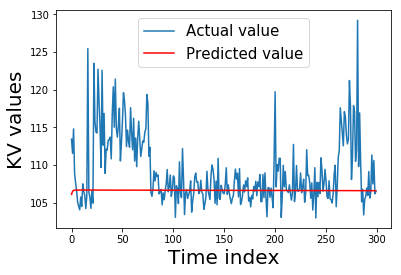

In [541]:
ARIMA_NMAE_PRD=[]

model_PRD = ARIMA(Y_train_np, order=(1,1,1))
model_fit_PRD = model_PRD.fit(disp=0)
output_PRD = model_fit_PRD.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1, typ='levels')
print(CalculateNMAE(output_PRD, Y_test_np))
ARIMA_NMAE_PRD.append(CalculateNMAE(output_PRD, Y_test_np))


plt.plot(Y_test_np[:300])
plt.plot(output_PRD[:300], color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)